# Imports and Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from shapely import wkt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

import geopandas as gpd

In [2]:
data = pd.read_csv("../data/analytics_trip_data_clustering.csv")

# Further Data Preparation and Cleaning

In [3]:
#Further settings for displaying results
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data.describe()

,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,price_per_mile,miles_per_hour,temperature,precipitation,sports_event_h3,sports_event_census_tract,poi_h3_res_8,poi_h3_res_7,poi_h3_res_6,poi_h3_res_4,poi_census_tract
count,46431.000000,46431.00000,4.643100e+04,4.643100e+04,46431.000000,46431.000000,46431.000000,46431.000000,33615.0,46431.000000,46431.000000,46428.000000,46431.000000,46431.000000,46431.000000,46431.0,46431.000000,46431.000000,46406.000000,46431.000000,46431.000000,46431.000000
mean,1092.750447,5.74129,1.703133e+10,1.703129e+10,25.470095,21.942151,18.273258,1.832420,0.0,0.810847,21.037345,18.464891,18.473273,11.519997,0.003144,0.0,0.000108,44.421184,215.643947,576.706683,3158.310159,20.724688
std,722.930018,4.84430,3.248592e+05,2.918937e+05,22.971879,20.309621,12.093793,2.975497,0.0,2.524228,14.696333,12.167275,8.799290,11.878381,0.029832,0.0,0.010377,39.259105,190.366575,301.978028,998.230362,21.439552
min,68.000000,0.19000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.010000,1.018868,-22.777778,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,9.000000,0.000000
25%,600.000000,2.30000,1.703108e+10,1.703107e+10,8.000000,6.000000,10.000000,0.000000,0.0,0.000000,11.250000,10.250000,12.375000,1.666667,0.000000,0.0,0.000000,11.000000,42.000000,411.000000,3481.000000,7.000000
50%,900.000000,4.11000,1.703122e+10,1.703119e+10,22.000000,16.000000,14.750000,0.000000,0.0,0.000000,16.500000,14.762989,16.636971,10.000000,0.000000,0.0,0.000000,48.000000,193.000000,628.000000,3481.000000,12.000000
75%,1378.000000,7.50000,1.703155e+10,1.703133e+10,32.000000,31.000000,22.500000,3.000000,0.0,1.000000,25.500000,22.750000,23.544664,22.222222,0.000000,0.0,0.000000,53.000000,345.000000,872.000000,3481.000000,33.000000
max,7029.000000,45.50000,1.703198e+10,1.703198e+10,77.000000,77.000000,888.880000,113.000000,0.0,400.000000,888.880000,888.880000,49.959184,35.555556,1.100000,0.0,1.000000,124.000000,512.000000,872.000000,3481.000000,67.000000


In [5]:
# Check for NaN values
nan_info = data.isna().sum()
print(nan_info)

trip_id                          0
taxi_id                          3
trip_start_timestamp             0
trip_end_timestamp               0
trip_seconds                     0
trip_miles                       0
pickup_census_tract              0
dropoff_census_tract             0
pickup_community_area            0
dropoff_community_area           0
fare                             0
tips                             0
tolls                        12816
extras                           0
trip_total                       0
payment_type                     0
company                          0
pickup_centroid_location         0
dropoff_centroid_location        0
h3_res_4_pickup                  0
h3_res_6_pickup                  0
h3_res_7_pickup                  0
h3_res_8_pickup                  0
h3_res_9_pickup                  0
h3_res_4_dropoff                 0
h3_res_6_dropoff                 0
h3_res_7_dropoff                 0
h3_res_8_dropoff                 0
h3_res_9_dropoff    

Column tolls seems to be useless, as many entries are zero, so we drop it. We also have some values that are missing in price_per_mile, which we also want to drop.

In [6]:
data.drop(columns=['tolls'], inplace=True)
data.dropna(inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46400 entries, 0 to 46430
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trip_id                    46400 non-null  object 
 1   taxi_id                    46400 non-null  object 
 2   trip_start_timestamp       46400 non-null  object 
 3   trip_end_timestamp         46400 non-null  object 
 4   trip_seconds               46400 non-null  float64
 5   trip_miles                 46400 non-null  float64
 6   pickup_census_tract        46400 non-null  int64  
 7   dropoff_census_tract       46400 non-null  int64  
 8   pickup_community_area      46400 non-null  float64
 9   dropoff_community_area     46400 non-null  float64
 10  fare                       46400 non-null  float64
 11  tips                       46400 non-null  float64
 12  extras                     46400 non-null  float64
 13  trip_total                 46400 non-null  float64


In [8]:
data.head(1)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,extras,trip_total,payment_type,company,pickup_centroid_location,dropoff_centroid_location,h3_res_4_pickup,h3_res_6_pickup,h3_res_7_pickup,h3_res_8_pickup,h3_res_9_pickup,h3_res_4_dropoff,h3_res_6_dropoff,h3_res_7_dropoff,h3_res_8_dropoff,h3_res_9_dropoff,trip_middle_timestamp,price_per_mile,miles_per_hour,date,temperature,precipitation,Game_End,sports_event_h3,sports_event_census_tract,poi_h3_res_8,poi_h3_res_7,poi_h3_res_6,poi_h3_res_4,poi_census_tract
0,55c95a71ea306ad47e2b7c6d72c3efae6adfc263,4136627ef25b9fad79910c55679c02d8e1f2a42925d29c89625b9a1b45192d184a2a2d368927e2eeccd104c0c21efb24cbe8a9d1c27bc3513911181e1c9ac216,2018-01-01 00:15:00,2018-01-01 00:30:00,1139.0,10.3,17031832900,17031251500,28.0,25.0,27.5,0.0,0.0,27.5,Cash,Yellow Cab,POINT (-87.6635175498 41.874005383),POINT (-87.7560467111 41.8906088526),842664dffffffff,862664cafffffff,872664ca9ffffff,882664ca91fffff,892664ca913ffff,842664dffffffff,862664c87ffffff,872664c80ffffff,882664c80bfffff,892664c80afffff,2018-01-01 00:22:30,27.5,32.554873,2018-01-01 01:53:00,-18.333333,0.0,2018-01-01 00:00:00,0.0,0.0,18.0,42.0,574.0,3481,2.0


## Adding new Features

### Time Features

In [9]:
data['trip_start_timestamp'] = pd.to_datetime(data['trip_start_timestamp'])
data['hour'] = data['trip_start_timestamp'].dt.hour
data['weekday'] = data['trip_start_timestamp'].dt.weekday
data['month'] = data['trip_start_timestamp'].dt.month

### Sports Data Features

To enhance our analysis, it might be valuable to further differentiate taxi rides based on whether they start at a sports location.

In [10]:
data['pick_from_sport'] = ((data['sports_event_h3'] != 0) | (data['sports_event_census_tract'] != 0)).astype(int)

### POI Data Features

To differentiate between taxi rides that originate from points of interest (POIs) and those that do not, we create a binary dummy variable.

In [11]:
data['pick_from_poi'] = ((data['poi_h3_res_8'] != 0) | (data['poi_census_tract'] != 0)).astype(int)

In [12]:
print(data['pick_from_sport'].sum())
print(data['pick_from_poi'].sum())
print(data['poi_h3_res_8'].describe())

5
46074
count    46400.000000
mean        44.447694
std         39.257244
min          0.000000
25%         11.000000
50%         48.000000
75%         53.000000
max        124.000000
Name: poi_h3_res_8, dtype: float64


Including sports event data does not seem to make much sense, as too few cab journeys can be linked to sports events. With the POI data it seems to be different, almost all trips can be linked to H3 data with Resolution 8. However, this results in another problem, as there are more POIs in a polygon at resolution 8. It becomes challenging to determine definitively whether a given taxi journey is directed towards a specific POI or merely passing through an area with several POIs. For this type of an analysis a more granular resolution would have been needed which in our case was limited due to computational resources.

### Distance to city Center

Separating taxi journeys based on their distance from the city center can provide valuable insights into different journey types and patterns. These distinct categories of journeys may be identified:

   - **City Center to City Center**: Trips that start and end within the city
   - **Out-of-Town to City Center**: Trips that start outside the city center but end within it.
   - **City Center to Out-of-Town**: Trips that start within the city center but end outside it.
   - **Out-of-Town to Out-of-Town**: Trips that neither start nor end within the city center.
   
To measure distances between two geographical points, the Haversine distance is used. Documentation of it can be found [here](https://pypi.org/project/haversine/).


In [13]:
from haversine import haversine_vector, Unit
chicago_coords = (41.8781, -87.6298)

data[['pickup_longitude', 'pickup_latitude']] = data['pickup_centroid_location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)
data[['dropoff_longitude', 'dropoff_latitude']] = data['dropoff_centroid_location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)

pickup_coords = data[['pickup_latitude', 'pickup_longitude']].values
dropoff_coords = data[['dropoff_latitude', 'dropoff_longitude']].values

chicago_coords_array = np.array([chicago_coords] * len(data))

data['distance_to_chicago'] = haversine_vector(pickup_coords, chicago_coords_array, Unit.MILES)

data['distance_from_chicago'] = haversine_vector(dropoff_coords, chicago_coords_array, Unit.MILES)

data.head(5)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,extras,trip_total,payment_type,company,pickup_centroid_location,dropoff_centroid_location,h3_res_4_pickup,h3_res_6_pickup,h3_res_7_pickup,h3_res_8_pickup,h3_res_9_pickup,h3_res_4_dropoff,h3_res_6_dropoff,h3_res_7_dropoff,h3_res_8_dropoff,h3_res_9_dropoff,trip_middle_timestamp,price_per_mile,miles_per_hour,date,temperature,precipitation,Game_End,sports_event_h3,sports_event_census_tract,poi_h3_res_8,poi_h3_res_7,poi_h3_res_6,poi_h3_res_4,poi_census_tract,hour,weekday,month,pick_from_sport,pick_from_poi,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_to_chicago,distance_from_chicago
0,55c95a71ea306ad47e2b7c6d72c3efae6adfc263,4136627ef25b9fad79910c55679c02d8e1f2a42925d29c89625b9a1b45192d184a2a2d368927e2eeccd104c0c21efb24cbe8a9d1c27bc3513911181e1c9ac216,2018-01-01 00:15:00,2018-01-01 00:30:00,1139.0,10.30,17031832900,17031251500,28.0,25.0,27.50,0.0,0.0,27.50,Cash,Yellow Cab,POINT (-87.6635175498 41.874005383),POINT (-87.7560467111 41.8906088526),842664dffffffff,862664cafffffff,872664ca9ffffff,882664ca91fffff,892664ca913ffff,842664dffffffff,862664c87ffffff,872664c80ffffff,882664c80bfffff,892664c80afffff,2018-01-01 00:22:30,27.500000,32.554873,2018-01-01 01:53:00,-18.333333,0.0,2018-01-01 00:00:00,0.0,0.0,18.0,42.0,574.0,3481,2.0,0,0,1,0,1,-87.663518,41.874005,-87.756047,41.890609,1.757563,6.551343
1,e14c597a315a9dad581ff2d434b20c33b6d677b3,6b97148e5dec989c75f5183f6cbf6aac41d6232a4805fe7866410223bd2a329173a3cb43b2c3a470315a37a7ad2cb78a5f93d5c5ca7079b41ef031540c4c8c93,2018-01-01 00:15:00,2018-01-01 00:15:00,300.0,1.20,17031242200,17031221300,24.0,22.0,6.50,0.0,0.0,6.50,Cash,Globe Taxi,POINT (-87.6763559892 41.90120699410001),POINT (-87.69915534320002 41.9227606205),842664dffffffff,862664cafffffff,872664cacffffff,882664cac3fffff,892664cac3bffff,842664dffffffff,862664ca7ffffff,872664ca1ffffff,882664ca11fffff,892664ca103ffff,2018-01-01 00:15:00,6.500000,14.400000,2018-01-01 01:53:00,-18.333333,0.0,2018-01-01 00:00:00,0.0,0.0,41.0,203.0,574.0,3481,12.0,0,0,1,0,1,-87.676356,41.901207,-87.699155,41.922761,2.878049,4.716284
2,7a213a855cd96ce3ee540011b05028c2a39340ea,390210c789e65184cf389dd3484688acf1956ab0c6618362f43f2f60da01b8b3a2afb54349a98fa29c22d66ef23d7dd607493da0c78794b18893cc57b8af4799,2018-01-01 00:30:00,2018-01-01 00:45:00,1087.0,4.38,17031062200,17031832900,6.0,28.0,14.75,0.0,0.0,14.75,Cash,Taxi Affiliation Service Yellow,POINT (-87.6559981815 41.9442266014),POINT (-87.6635175498 41.874005383),842664dffffffff,862664c17ffffff,872664c16ffffff,882664c163fffff,892664c1607ffff,842664dffffffff,862664cafffffff,872664ca9ffffff,882664ca91fffff,892664ca913ffff,2018-01-01 00:37:30,14.750000,14.505980,2018-01-01 01:53:00,-18.333333,0.0,2018-01-01 00:00:00,0.0,0.0,53.0,193.0,628.0,3481,15.0,0,0,1,0,1,-87.655998,41.944227,-87.663518,41.874005,4.763353,1.757563
3,8efe851ac116c76968f9bce7c2736f5ab904a630,0881b7b36b4aad06e5ee59472465b15a6620637f694aae59e671eae69d6813cbce85e8da46949f71f5bd94b08f1db3323debbd8333302d97d22584ef366b2e10,2018-01-01 00:30:00,2018-01-01 01:00:00,1339.0,5.35,17031081000,17031062200,8.0,6.0,18.50,0.0,1.0,19.50,Cash,Taxi Affiliation Service Yellow,POINT (-87.6333080367 41.899602111),POINT (-87.6559981815 41.9442266014),842664dffffffff,862664c1fffffff,872664c1effffff,882664c1edfffff,892664c1ecfffff,842664dffffffff,862664c17ffffff,872664c16ffffff,882664c163fffff,892664c1607ffff,2018-01-01 00:45:00,18.686916,14.383869,2018-01-01 01:53:00,-18.333333,0.0,2018-01-01 00:00:00,0.0,0.0,48.0,512.0,872.0,3481,7.0,0,0,1,0,1,-87.633308,41.899602,-87.655998,41.944227,1.496572,4.763353
4,b94c47cd2a18f51214fa02af2e6b5456e3ba497b,64fff61f756e79ac9c70a32fd276cf1830815a0e4ee80e71b453132e59766928363c1dbaf009c36a0e68172e680e19ae9727d28b17fadf5f93559dbb9a64dd56,2018-01-01 00:30:00,2018-01-01 00:45:00,1098.0,5.80,17031221300,17031830700,22.0,3.0

## Feature Selection

We have focused on numerical features for our analysis and will address geospatial data for kernel density estimation later in the notebook. Variables like trip_id, taxi_id, and date from the weather data join are not relevant for our purposes. Precipitation data is sparse, with the 75th percentile still at 0, so it’s excluded. Similarly, payment_type and company do not provide useful insights into a typical taxi ride, so they are not included either. Instead, we are using fare as a key feature for clustering since it represents the total price of the ride. We will also use other data like temperature, time, day, and month to describe the taxi journey and conditions.

In [14]:
features = ["trip_seconds", "price_per_mile", "miles_per_hour", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]
#features = ["trip_seconds", "temperature","distance_to_chicago"]

In [15]:
Cluster_all = data[features]

In [16]:
Cluster_all.describe()

,trip_seconds,price_per_mile,miles_per_hour,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
count,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000
mean,1092.613901,18.460521,18.470377,5.739187,18.270046,13.023922,3.044547,6.345129,11.520426,4.519230,4.852211
std,722.952385,12.163583,8.797340,4.842377,12.089413,6.733903,1.971974,3.378069,11.877989,4.581393,3.304016
min,68.000000,0.010000,1.018868,0.190000,0.010000,0.000000,0.000000,1.000000,-22.777778,0.242878,0.242878
25%,600.000000,10.250000,12.375000,2.300000,10.000000,8.000000,1.000000,3.000000,1.666667,1.496572,2.878049
50%,900.000000,14.761280,16.636364,4.110000,14.750000,14.000000,3.000000,6.000000,10.000000,2.878049,4.716284
75%,1378.000000,22.750000,23.538462,7.500000,22.500000,19.000000,5.000000,9.000000,22.222222,6.206846,6.206846
max,7029.000000,888.880000,49.959184,45.500000,888.880000,23.000000,6.000000,12.000000,35.555556,16.207510,16.207510


### Converting hours, months, weekday into dummies

In [17]:
Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=["hour", "weekday", "month"], dtype=int)
#Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=[], dtype=int)

In [18]:
Cluster_all_ohe.head(1)

,trip_seconds,price_per_mile,miles_per_hour,trip_miles,fare,temperature,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1139.0,27.5,32.554873,10.3,27.5,-18.333333,1.757563,6.551343,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
Cluster_all_ohe.columns

Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

## Data Normalisation

In [20]:
columns_to_normalize=["trip_seconds", "miles_per_hour", "trip_miles","price_per_mile", "fare", "temperature","distance_to_chicago", "distance_from_chicago"]
#columns_to_normalize=["trip_seconds", "temperature","distance_to_chicago"]

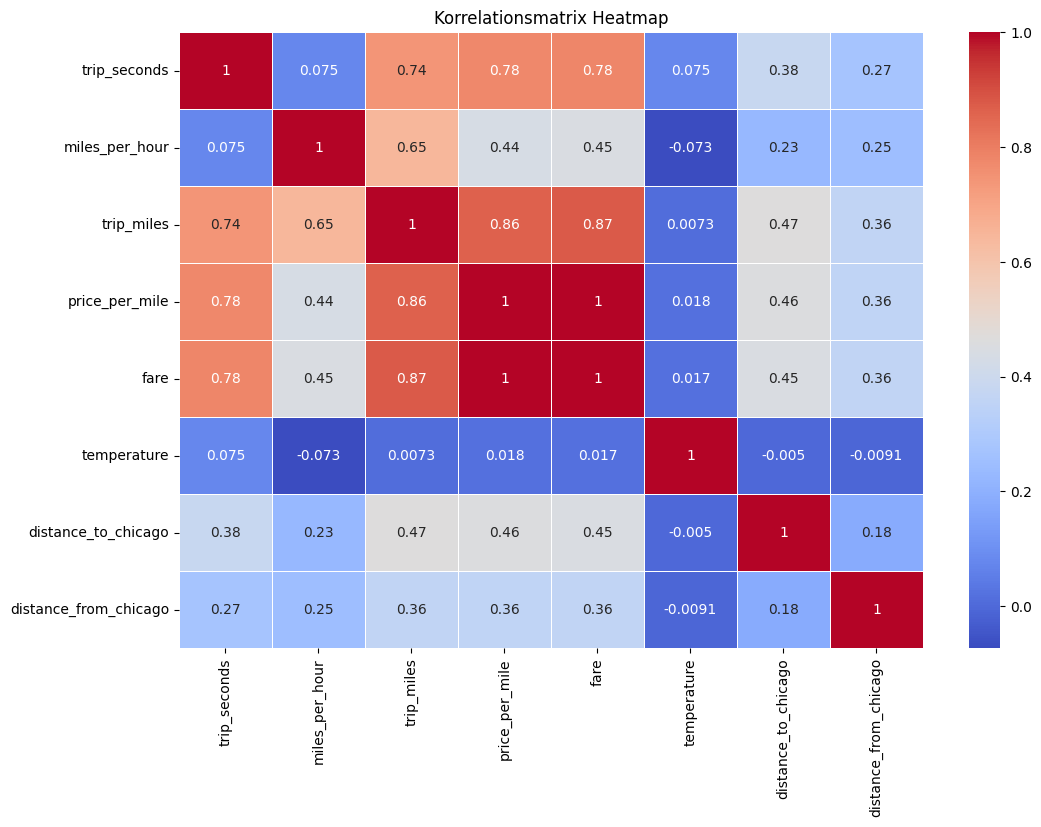

In [21]:
# 1. Berechnung der Korrelationsmatrix
correlation_matrix = Cluster_all_ohe[columns_to_normalize].corr()

# 2. Erstellen einer Heatmap zur Visualisierung der Korrelationsmatrix
plt.figure(figsize=(12, 8))  # Größe der Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korrelationsmatrix Heatmap')
plt.show()

In [22]:
scaler = MinMaxScaler()
Cluster_all_ohe[columns_to_normalize] = scaler.fit_transform(Cluster_all_ohe[columns_to_normalize])
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')


In [23]:
Cluster_all_ohe.describe()

,trip_seconds,price_per_mile,miles_per_hour,trip_miles,fare,temperature,distance_to_chicago,distance_from_chicago,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000
mean,0.147193,0.020757,0.356588,0.122472,0.020543,0.587969,0.267864,0.288721,0.041724,0.033901,0.029203,0.024655,0.022457,0.020625,0.024547,0.031487,0.035668,0.038578,0.039547,0.045259,0.045970,0.047953,0.049116,0.050151,0.050625,0.052435,0.055043,0.054612,0.053319,0.054461,0.052909,0.045754,0.135625,0.137457,0.137522,0.147349,0.157802,0.146681,0.137565,0.082263,0.081659,0.091961,0.087091,0.090582,0.089806,0.082737,0.086724,0.080884,0.078944,0.074978,0.072371
std,0.103858,0.013684,0.179757,0.106872,0.013601,0.203623,0.286971,0.206958,0.199960,0.180976,0.168376,0.155074,0.148166,0.142127,0.154743,0.174632,0.185463,0.192588,0.194895,0.207873,0.209422,0.213668,0.216113,0.218259,0.219233,0.222906,0.228067,0.227224,0.224671,0.226928,0.223855,0.208954,0.342394,0.344333,0.344401,0.354457,0.364559,0.353791,0.344446,0.274768,0.273848,0.288974,0.281971,0.287017,0.285907,0.275487,0.281433,0.272659,0.269654,0.263359,0.259103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076426,0.011520,0.232040,0.046568,0.011239,0.419048,0.078529,0.165063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.119523,0.016596,0.319113,0.086515,0.016583,0.561905,0.165063,0.280207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.188191,0.025583,0.460144,0.161333,0.025302,0.771429,0.373574,0.373574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.

# PCA

(46400, 51)
the total variancein our dataset is 2.9499835444558644
the 95% of the variance in our dataset is 2.8024843672330713


Text(0, 0.5, '% explained_variance_ratio')

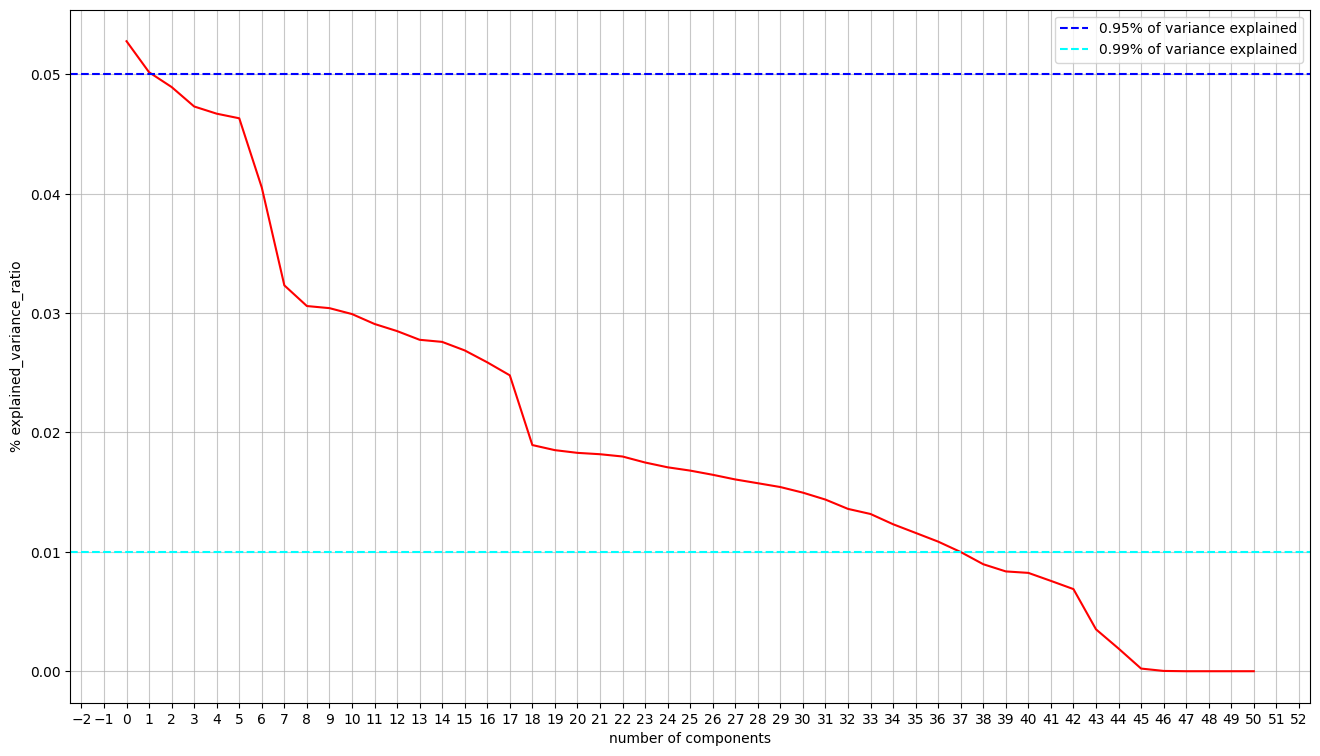

In [24]:
number_comp= Cluster_all_ohe.shape[1]
print(Cluster_all_ohe.shape)
pca= PCA(n_components=number_comp, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

total_variance =sum(pca.explained_variance_)
variance95= total_variance * 0.95
print(f"the total variancein our dataset is {total_variance}")
print(f"the 95% of the variance in our dataset is {variance95}")

a=zip(range(0,number_comp), pca.explained_variance_)
a= pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

plt.figure(1, figsize=(16,9))
plt.plot(pca.explained_variance_ratio_, c="r")
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.axhline(y=0.05, color='blue', linestyle='--', label='0.95% of variance explained')
plt.axhline(y=0.01, color='cyan', linestyle='--', label='0.99% of variance explained')
plt.grid(True, alpha=0.7)
plt.legend()
plt.xlabel("number of components")
plt.ylabel("% explained_variance_ratio")

## Finding Number of Clusters

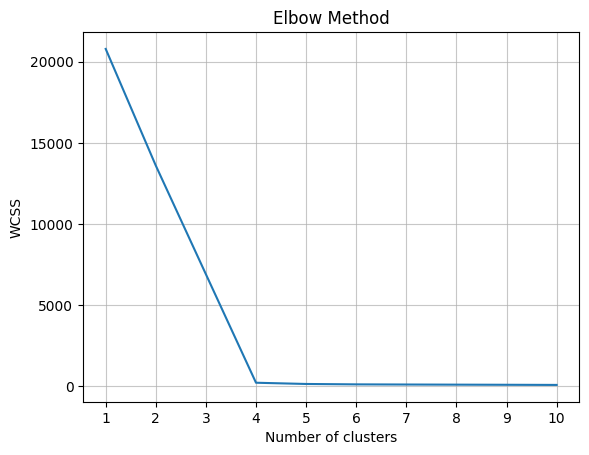

In [25]:
pca= PCA(n_components=3, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

# Hard Clustering

In [26]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=47)
kmeans.fit(X_pca)

KMeans(n_clusters=4, random_state=47)

In [27]:
labels_hard = kmeans.labels_

# Calculate the silhouette score for c_raw2
silhouette_score_hard = silhouette_score(X_pca, labels_hard)
print(f"Silhouette Score for 4 clusters: {silhouette_score_hard}")

Silhouette Score for 4 clusters: 0.9245131560024487


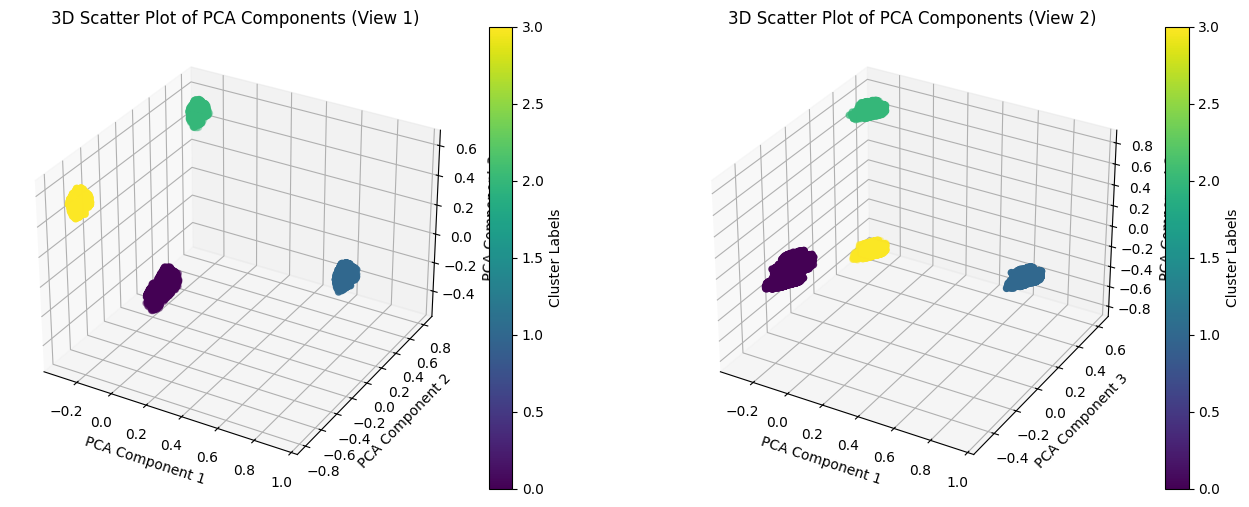

In [28]:
# Erstellen einer Figur mit zwei Subplots
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_hard, cmap='viridis')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('3D Scatter Plot of PCA Components (View 1)')
colorbar1 = fig.colorbar(scatter1, ax=ax1)
colorbar1.set_label('Cluster Labels')


ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], X_pca[:, 1], c=labels_hard, cmap='viridis')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 3')
ax2.set_zlabel('PCA Component 2')
ax2.set_title('3D Scatter Plot of PCA Components (View 2)')
colorbar2 = fig.colorbar(scatter2, ax=ax2)
colorbar2.set_label('Cluster Labels')

# Plot anzeigen
plt.show()

In [29]:
Cluster_all_knn = Cluster_all.copy()
Cluster_all_knn["clusters"]= labels_hard

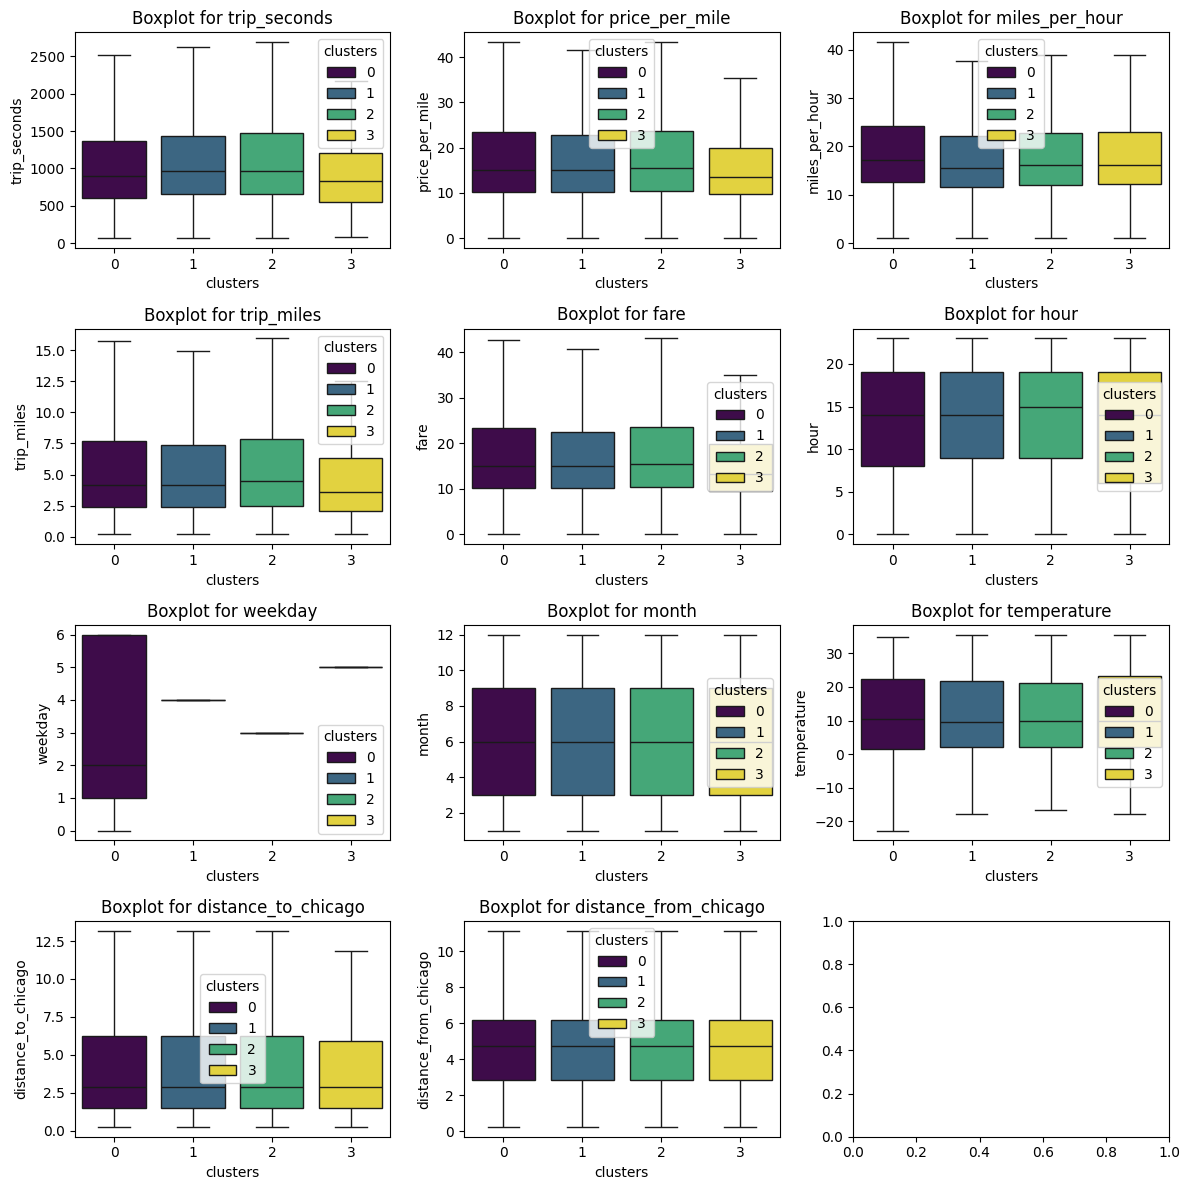

In [30]:
features_hard = features
# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_hard):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_knn, hue='clusters', palette='viridis', ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

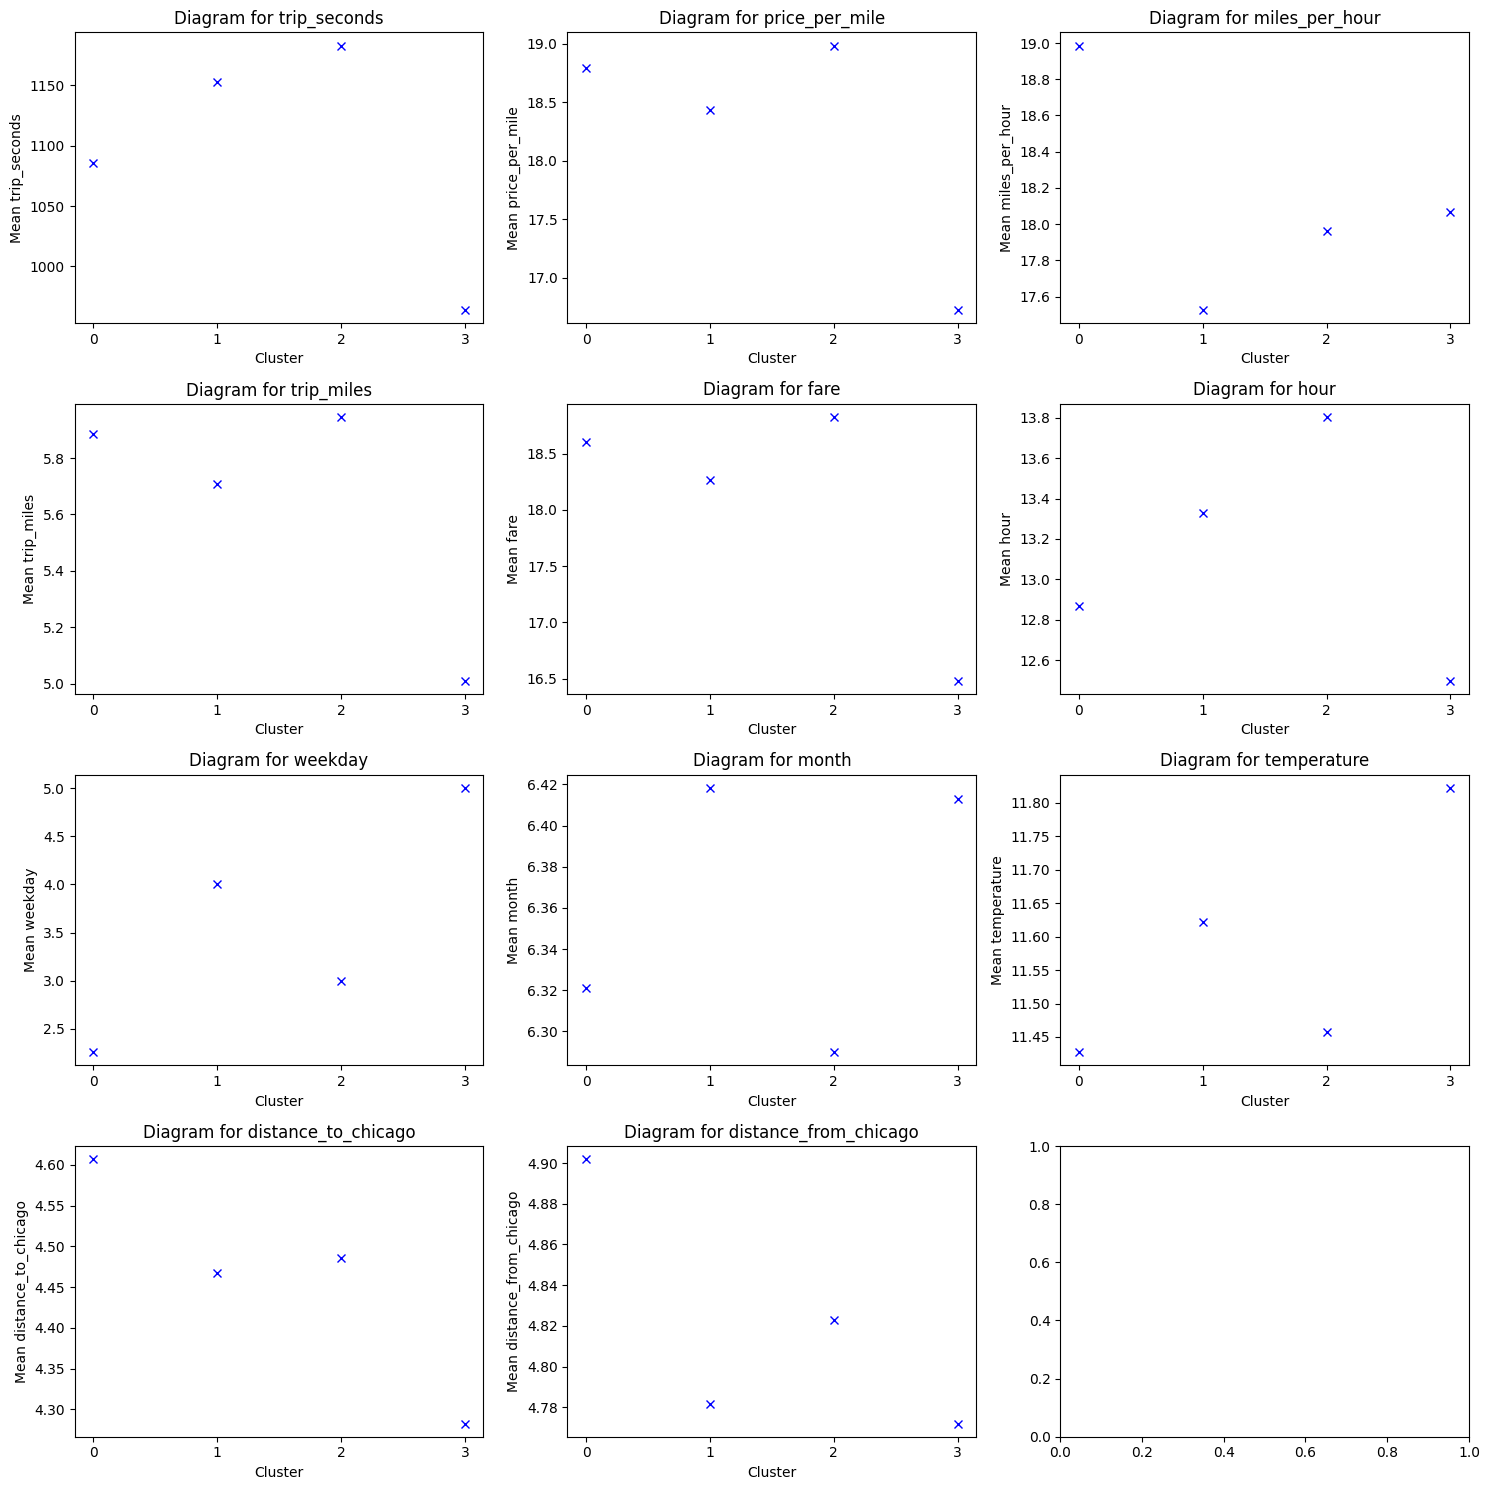

In [31]:
# Features to plot
features_hard = features

cluster_centers = Cluster_all_knn.groupby('clusters').mean().reset_index()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()


for i, feature in enumerate(features_hard):
    axes[i].plot(cluster_centers['clusters'], cluster_centers[feature], marker='x', linestyle='', color='b', label=f'Feature: {feature}')
    
    axes[i].set_title(f'Diagram for {feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Mean {feature}')
    axes[i].xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()

plt.show()

In [32]:
# Inspect mean values
cluster_centers

,clusters,trip_seconds,price_per_mile,miles_per_hour,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
0,0,1085.386161,18.791068,18.986271,5.887307,18.600537,12.867781,2.258227,6.320857,11.427145,4.606692,4.901834
1,1,1152.804425,18.431666,17.527266,5.709605,18.266721,13.327233,4.000000,6.418192,11.622659,4.466661,4.781834
2,2,1183.024426,18.985853,17.961945,5.946580,18.827617,13.805031,3.000000,6.289893,11.457429,4.485608,4.822761
3,3,964.048780,16.728542,18.067769,5.009126,16.478418,12.496474,5.000000,6.412724,11.822330,4.282702,4.772056


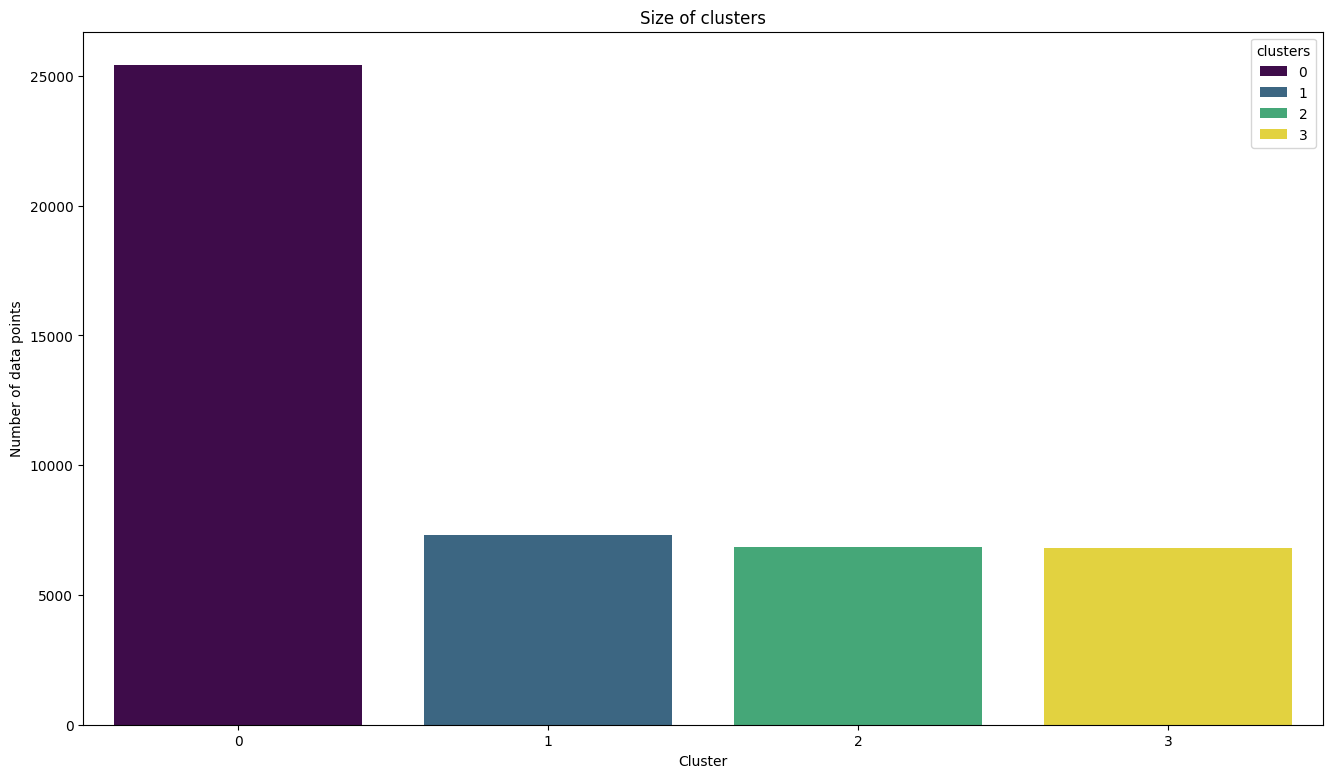

In [33]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_knn, x="clusters", hue="clusters", palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of data points')
plt.title('Size of clusters')
plt.show()

In [34]:
cluster_sizes = Cluster_all_knn['clusters'].value_counts()
cluster_sizes

clusters
0    25435
1     7322
2     6837
3     6806
Name: count, dtype: int64

In [35]:
'''Cluster_all_knn[columns_to_normalize] = scaler.fit_transform(Cluster_all_knn[columns_to_normalize])'''
Cluster_all_knn.describe()

,trip_seconds,price_per_mile,miles_per_hour,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago,clusters
count,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000,46400.000000
mean,1092.613901,18.460521,18.470377,5.739187,18.270046,13.023922,3.044547,6.345129,11.520426,4.519230,4.852211,0.892543
std,722.952385,12.163583,8.797340,4.842377,12.089413,6.733903,1.971974,3.378069,11.877989,4.581393,3.304016,1.127263
min,68.000000,0.010000,1.018868,0.190000,0.010000,0.000000,0.000000,1.000000,-22.777778,0.242878,0.242878,0.000000
25%,600.000000,10.250000,12.375000,2.300000,10.000000,8.000000,1.000000,3.000000,1.666667,1.496572,2.878049,0.000000
50%,900.000000,14.761280,16.636364,4.110000,14.750000,14.000000,3.000000,6.000000,10.000000,2.878049,4.716284,0.000000
75%,1378.000000,22.750000,23.538462,7.500000,22.500000,19.000000,5.000000,9.000000,22.222222,6.206846,6.206846,2.000000
max,7029.000000,888.880000,49.959184,45.500000,888.880000,23.000000,6.000000,12.000000,35.555556,16.207510,16.207510,3.000000


In [36]:
# Trip Duration: long, middle, short
Cluster_all_knn['trip_duration_category'] = [
    'short' if x < 300 else 'middle' if x < 900 else 'long' 
    for x in Cluster_all_knn['trip_seconds']
]

# Price per Mile: expensive, middle, cheap
Cluster_all_knn['price_per_mile_category'] = [
    'cheap' if x < 9.9 else 'middle' if x < 16.0 else 'expensive' 
    for x in Cluster_all_knn['price_per_mile']
]

# Miles per Hour: fast, middle, slow
Cluster_all_knn['miles_per_hour_category'] = [
    'slow' if x < 13 else 'middle' if x < 30 else 'fast' 
    for x in Cluster_all_knn['miles_per_hour']
]

# Trip Miles: long, middle, short
Cluster_all_knn['trip_miles_category'] = [
    'short' if x < 5 else 'middle' if x < 20 else 'long' 
    for x in Cluster_all_knn['trip_miles']
]

# Hour: morning, afternoon, evening, night
Cluster_all_knn['hour_category'] = [
    'night' if x < 5 else 'morning' if x < 6 else 'afternoon' if x < 17 else 'evening'
    for x in Cluster_all_knn['hour']
]

# Weekday: weekday, weekend
Cluster_all_knn['weekday_category'] = [
    'weekend' if day >= 5 else 'weekday' 
    for day in Cluster_all_knn['weekday']
]

# Month: winter, spring, summer, fall (USA)
Cluster_all_knn['month_category'] = [
    'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' 
    for x in Cluster_all_knn['month']
]

# Temperature: hot, mild, cold
Cluster_all_knn['temperature_category'] = [
    'cold' if x < -6.0 else 'mild' if x < 4.0 else 'hot' 
    for x in Cluster_all_knn['temperature']
]

# Distance to Chicago: near, middle, far
Cluster_all_knn['distance_to_chicago_category'] = [
    'near' if x < 3 else 'middle' if x < 6 else 'far' 
    for x in Cluster_all_knn['distance_to_chicago']
]

# Distance from Chicago: near, middle, far
Cluster_all_knn['distance_from_chicago_category'] = [
    'near' if x < 3 else 'middle' if x < 6 else 'far' 
    for x in Cluster_all_knn['distance_to_chicago']
]
Cluster_all_knn.columns

Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'hour', 'weekday', 'month', 'temperature',
       'distance_to_chicago', 'distance_from_chicago', 'clusters',
       'trip_duration_category', 'price_per_mile_category',
       'miles_per_hour_category', 'trip_miles_category', 'hour_category',
       'weekday_category', 'month_category', 'temperature_category',
       'distance_to_chicago_category', 'distance_from_chicago_category'],
      dtype='object')

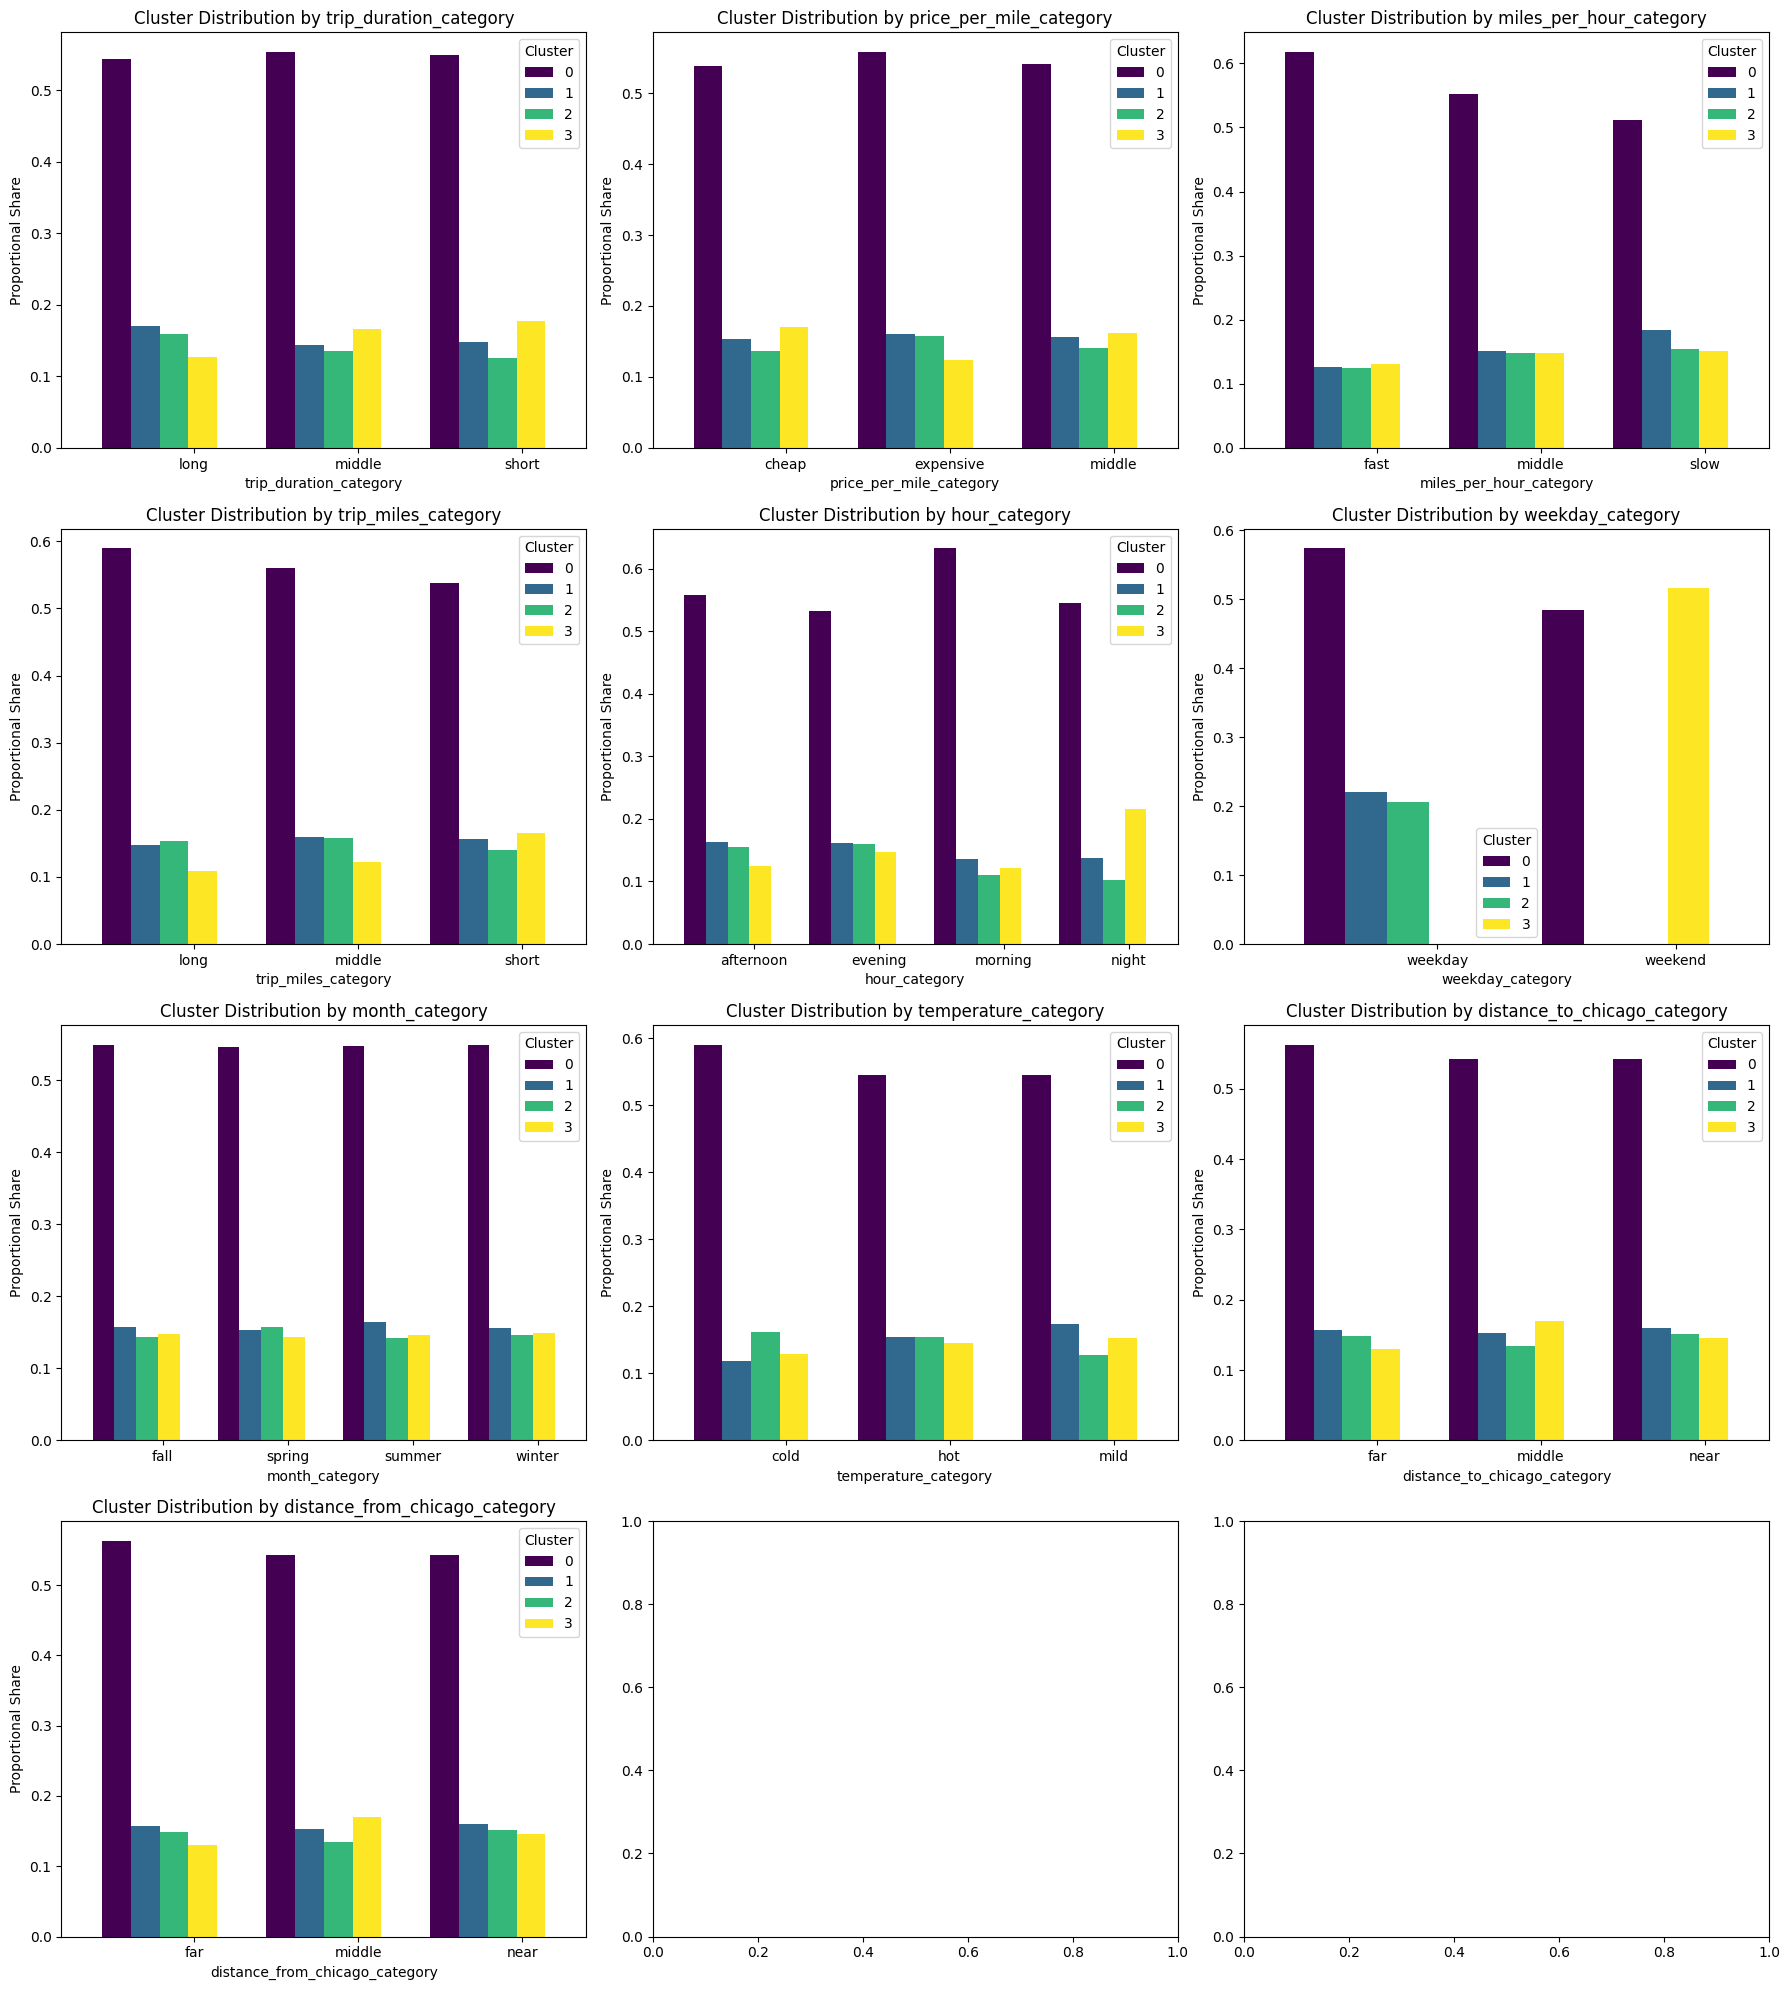

In [37]:
# Speichere alle generierten Kategorien in einer Liste
generated_categories = [
    'trip_duration_category',
    'price_per_mile_category',
    'miles_per_hour_category',
    'trip_miles_category',
    'hour_category',
    'weekday_category',
    'month_category',
    'temperature_category',
    'distance_to_chicago_category',
    'distance_from_chicago_category'
]

# Erstelle eine Grafik mit 4x3 Subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))  # 4 Zeilen, 3 Spalten

# Schleife durch alle Kategorien
for i, category in enumerate(generated_categories):
    ax = axes[i // 3, i % 3]  # Position des Subplots auswählen

    # Erstelle eine Kreuztabelle, um den Anteil der Cluster pro Kategorie zu berechnen
    cross_tab = pd.crosstab(Cluster_all_knn[category], Cluster_all_knn['clusters'], normalize='index')

    # Plotten
    cross_tab.plot(kind='bar', stacked=False, position=0.8, width=0.7, colormap='viridis', ax=ax)

    # Achsen und Titel einstellen
    ax.set_title(f'Cluster Distribution by {category}')
    ax.set_xlabel(category)
    ax.set_ylabel('Proportional Share')
    ax.legend(title='Cluster')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

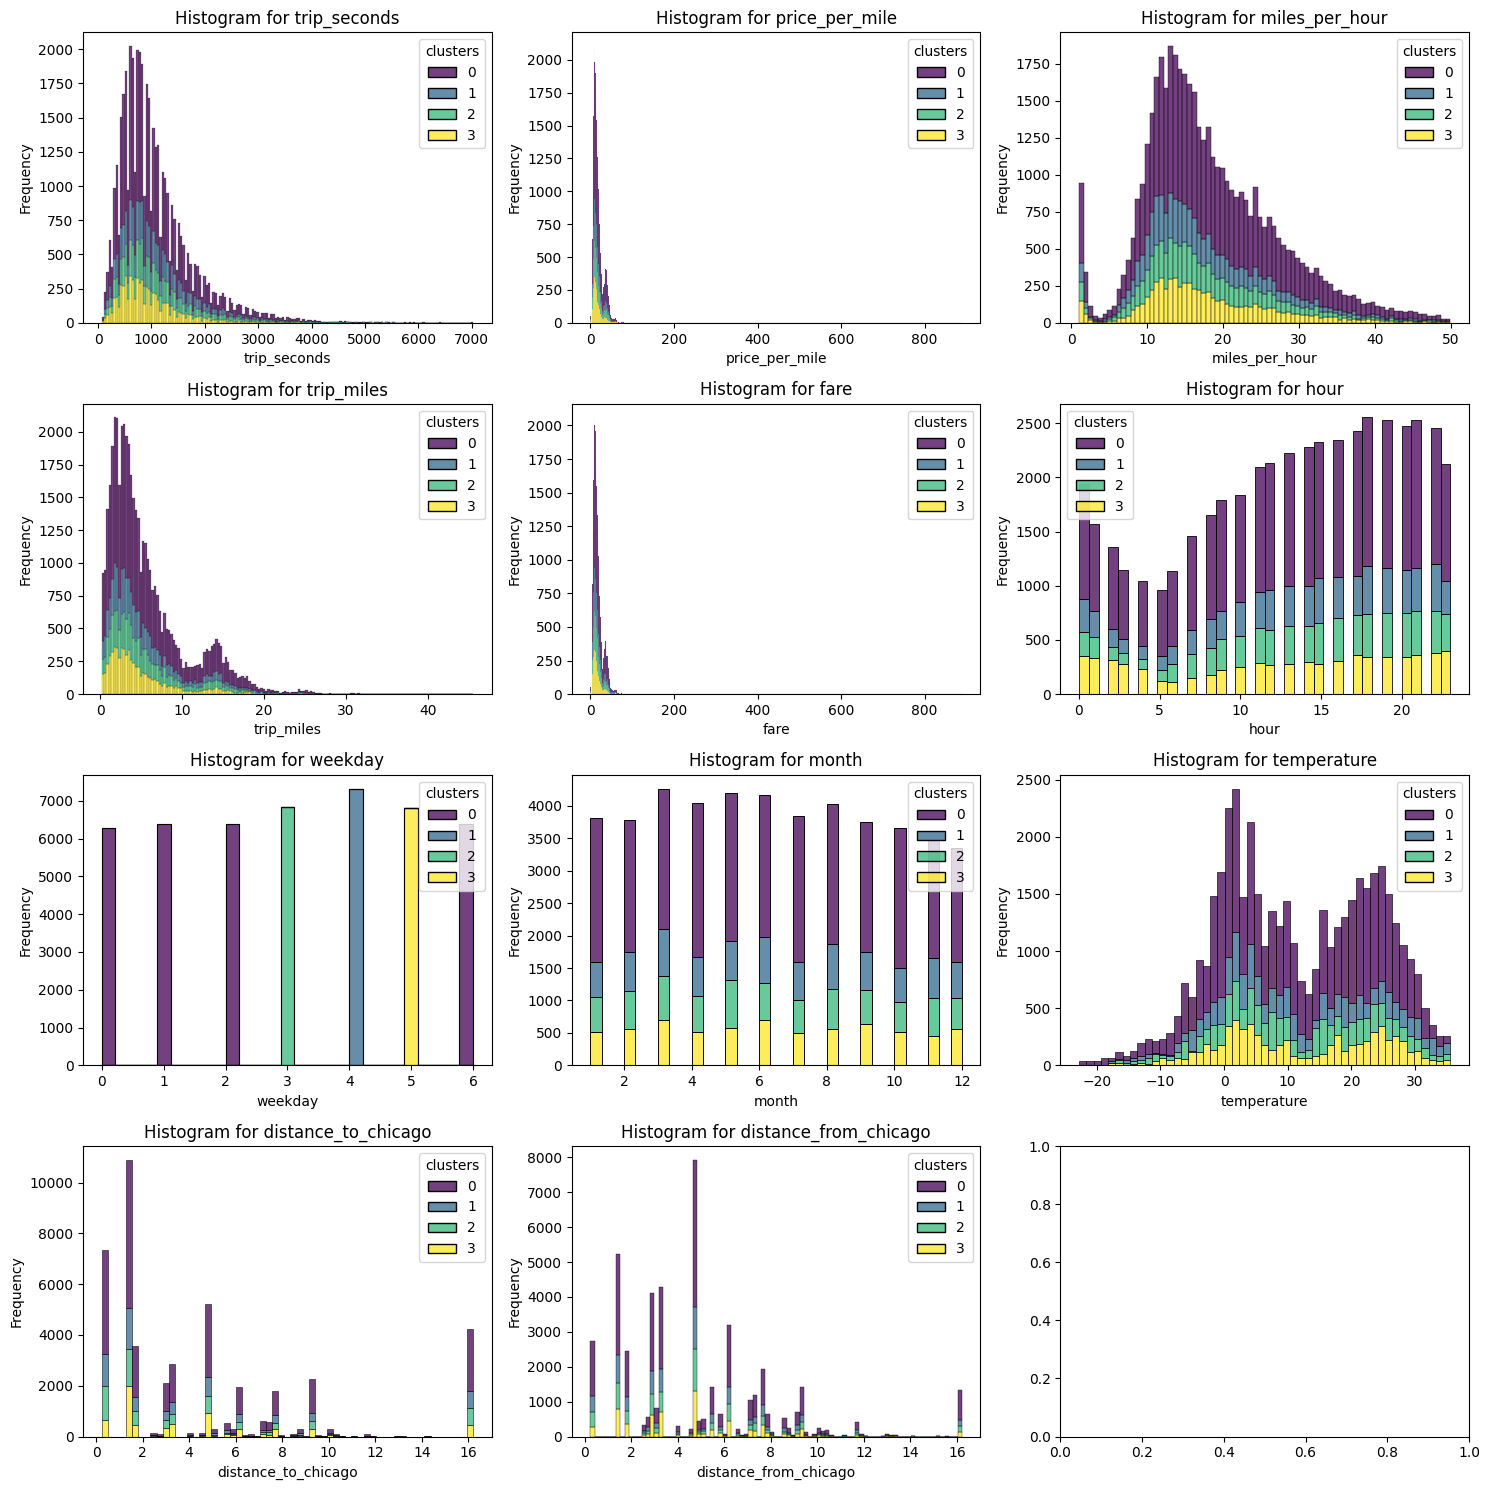

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()


for i, feature in enumerate(features_hard):
    sns.histplot(data=Cluster_all_knn, x=feature, hue='clusters', multiple='stack', palette='viridis', ax=axes[i])
    
    axes[i].set_title(f'Histogram for {feature}')
    axes[i].set_xlabel(f'{feature}')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

In [39]:
'''Cluster_all_knn[columns_to_normalize] = scaler.fit_transform(Cluster_all_knn[columns_to_normalize])'''

'Cluster_all_knn[columns_to_normalize] = scaler.fit_transform(Cluster_all_knn[columns_to_normalize])'

## Soft Clustering

In [40]:
gmm = GaussianMixture(n_components=4).fit(X_pca)
labels_soft = gmm.predict(X_pca)

In [41]:
silhouette_score_soft = silhouette_score(X_pca, labels_soft)
print(f"Silhouette Score for 4 clusters: {silhouette_score_soft}")

Silhouette Score for 4 clusters: 0.9245131560024487


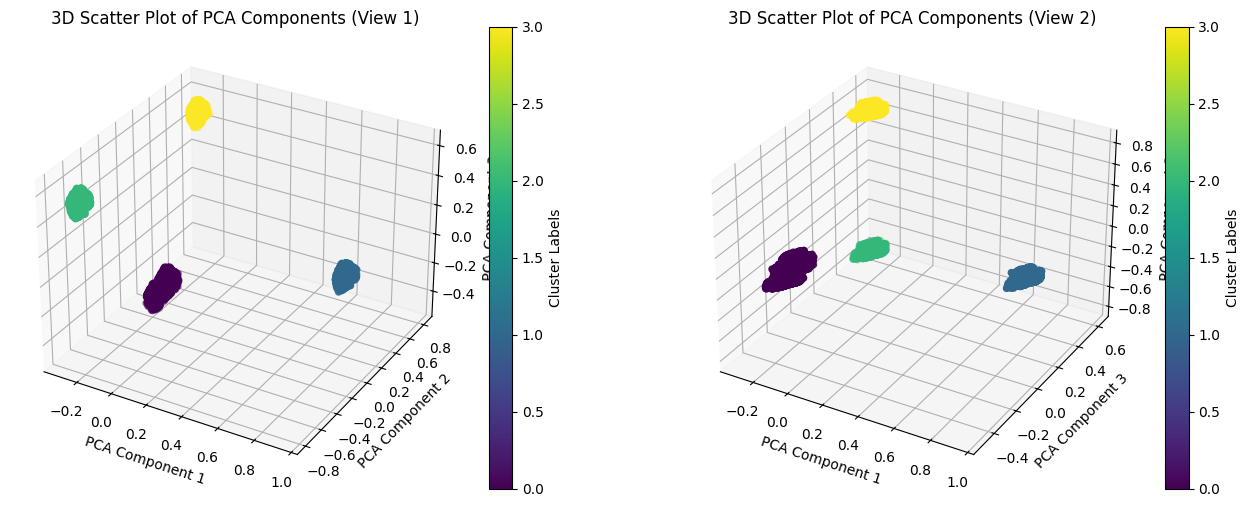

In [42]:
# Erstellen einer Figur mit zwei Subplots
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels_soft, cmap='viridis')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('3D Scatter Plot of PCA Components (View 1)')
colorbar1 = fig.colorbar(scatter1, ax=ax1)
colorbar1.set_label('Cluster Labels')


ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 2], X_pca[:, 1], c=labels_soft, cmap='viridis')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 3')
ax2.set_zlabel('PCA Component 2')
ax2.set_title('3D Scatter Plot of PCA Components (View 2)')
colorbar2 = fig.colorbar(scatter2, ax=ax2)
colorbar2.set_label('Cluster Labels')

# Plot anzeigen
plt.show()

In [43]:
probs = gmm.predict_proba(X_pca)
print(probs[:5])

[[1.00000000e+000 0.00000000e+000 4.40678273e-280 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 3.11683302e-277 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 5.21405734e-282 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 6.49239596e-279 0.00000000e+000]
 [1.00000000e+000 0.00000000e+000 1.03960755e-283 0.00000000e+000]]


In [44]:
Cluster_all_gmm = Cluster_all.copy()
Cluster_all_gmm["clusters"]= labels_soft

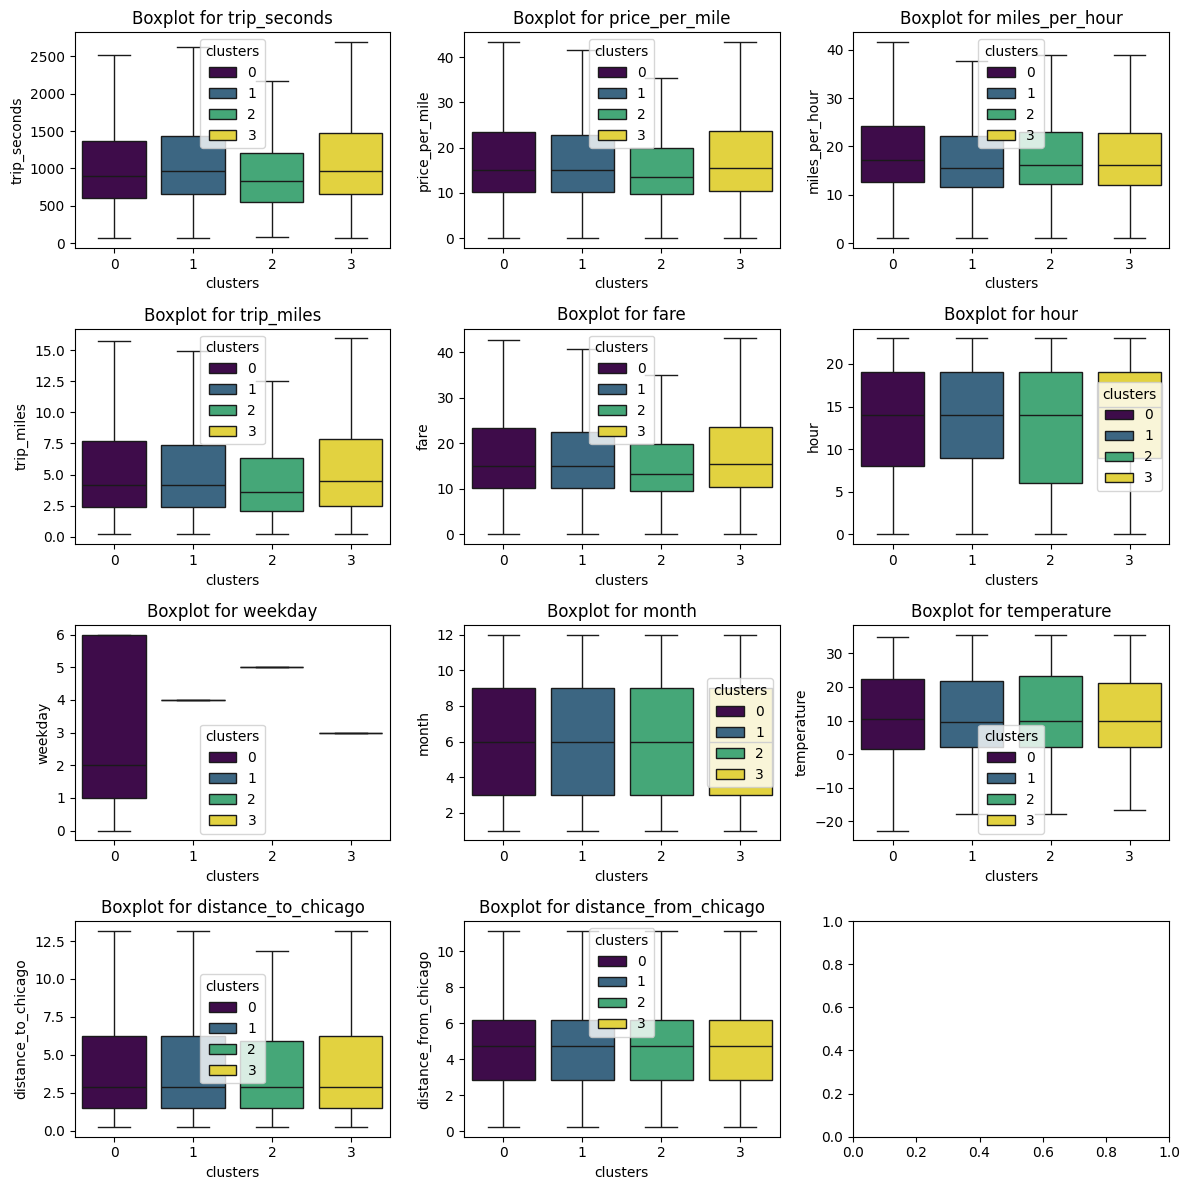

In [45]:
features_soft = features

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_soft):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_gmm, hue='clusters', palette='viridis', ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

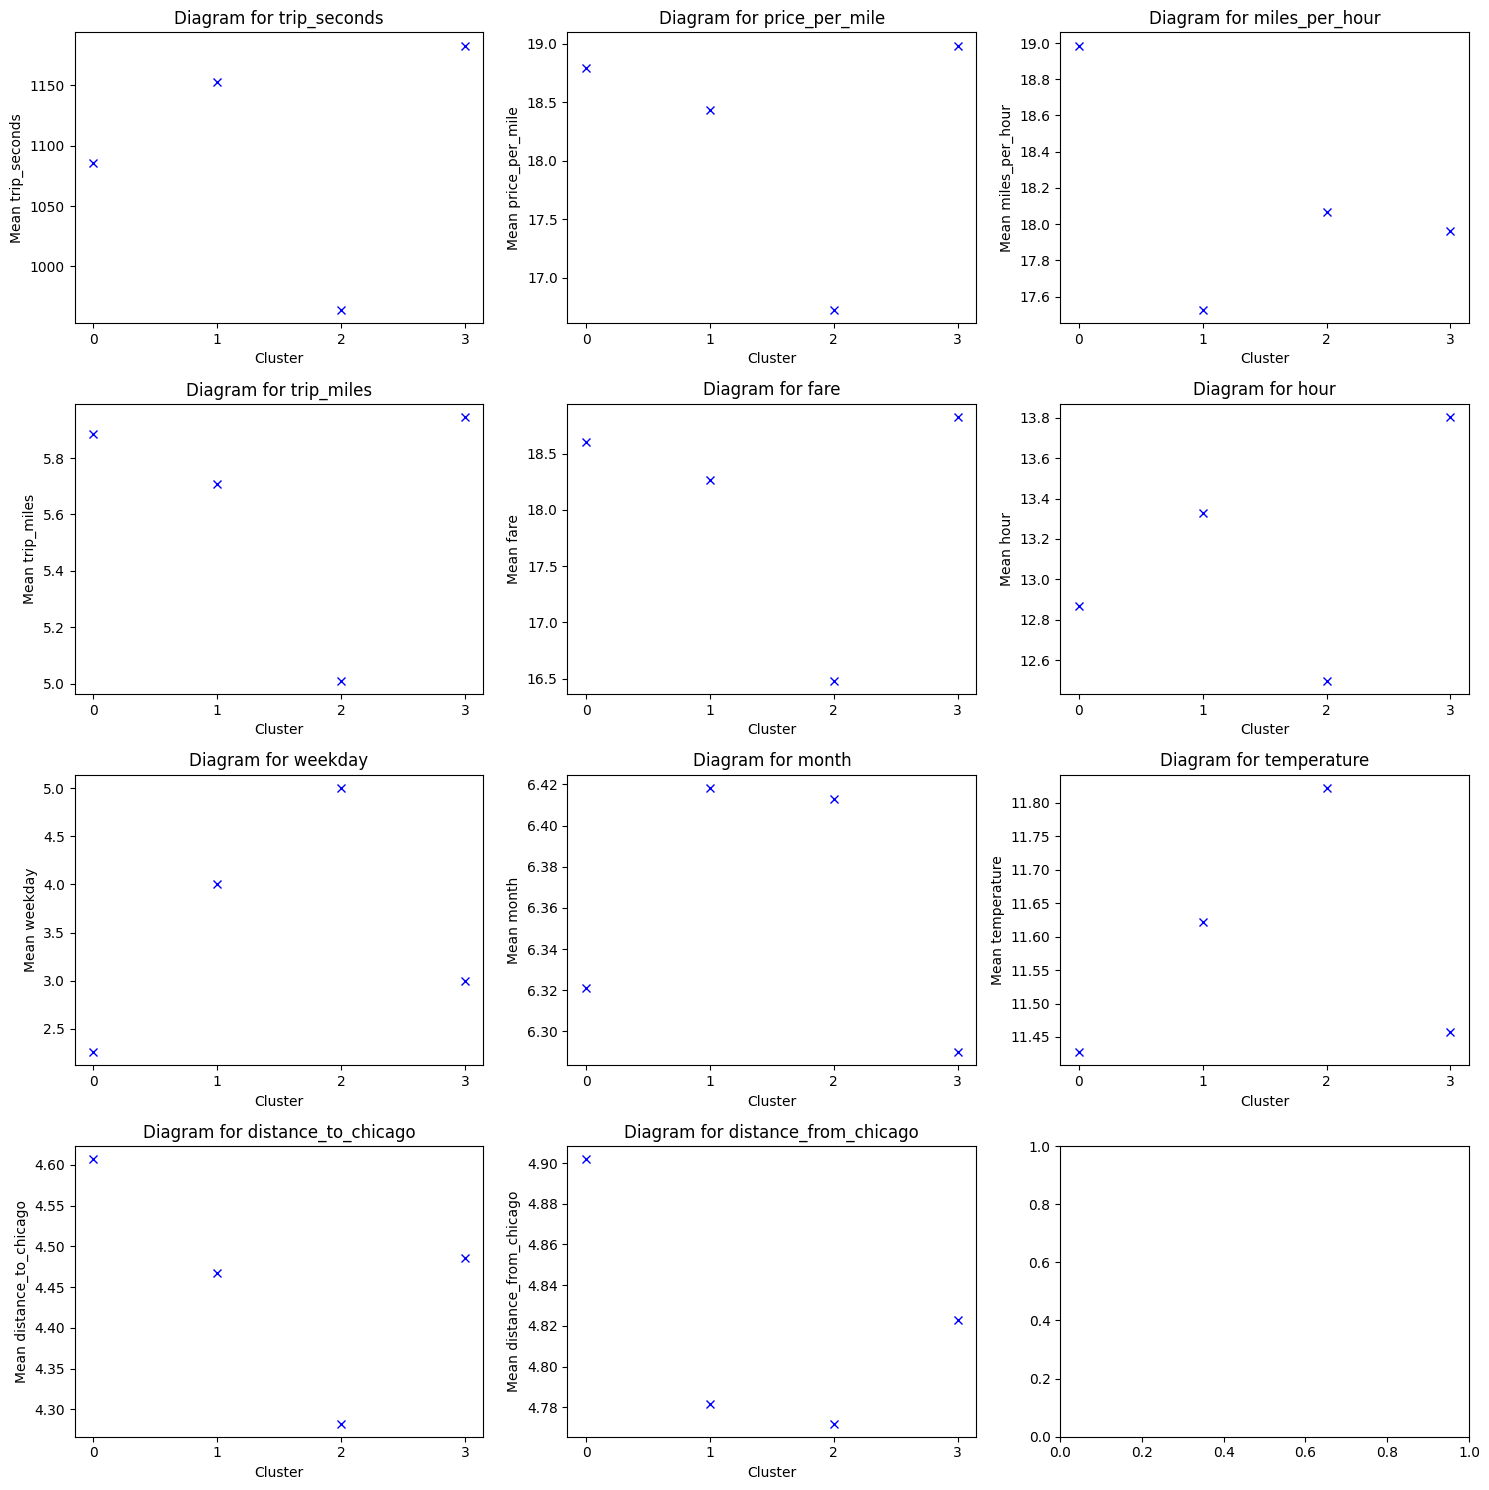

In [46]:
# Features to plot
features_soft = features
cluster_centers = Cluster_all_gmm.groupby('clusters').mean().reset_index()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()


for i, feature in enumerate(features_hard):
    axes[i].plot(cluster_centers['clusters'], cluster_centers[feature], marker='x', linestyle='', color='b', label=f'Feature: {feature}')
    
    axes[i].set_title(f'Diagram for {feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Mean {feature}')
    axes[i].xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()

plt.show()

In [47]:
# Inspect mean values
cluster_centers

,clusters,trip_seconds,price_per_mile,miles_per_hour,trip_miles,fare,hour,weekday,month,temperature,distance_to_chicago,distance_from_chicago
0,0,1085.386161,18.791068,18.986271,5.887307,18.600537,12.867781,2.258227,6.320857,11.427145,4.606692,4.901834
1,1,1152.804425,18.431666,17.527266,5.709605,18.266721,13.327233,4.000000,6.418192,11.622659,4.466661,4.781834
2,2,964.048780,16.728542,18.067769,5.009126,16.478418,12.496474,5.000000,6.412724,11.822330,4.282702,4.772056
3,3,1183.024426,18.985853,17.961945,5.946580,18.827617,13.805031,3.000000,6.289893,11.457429,4.485608,4.822761


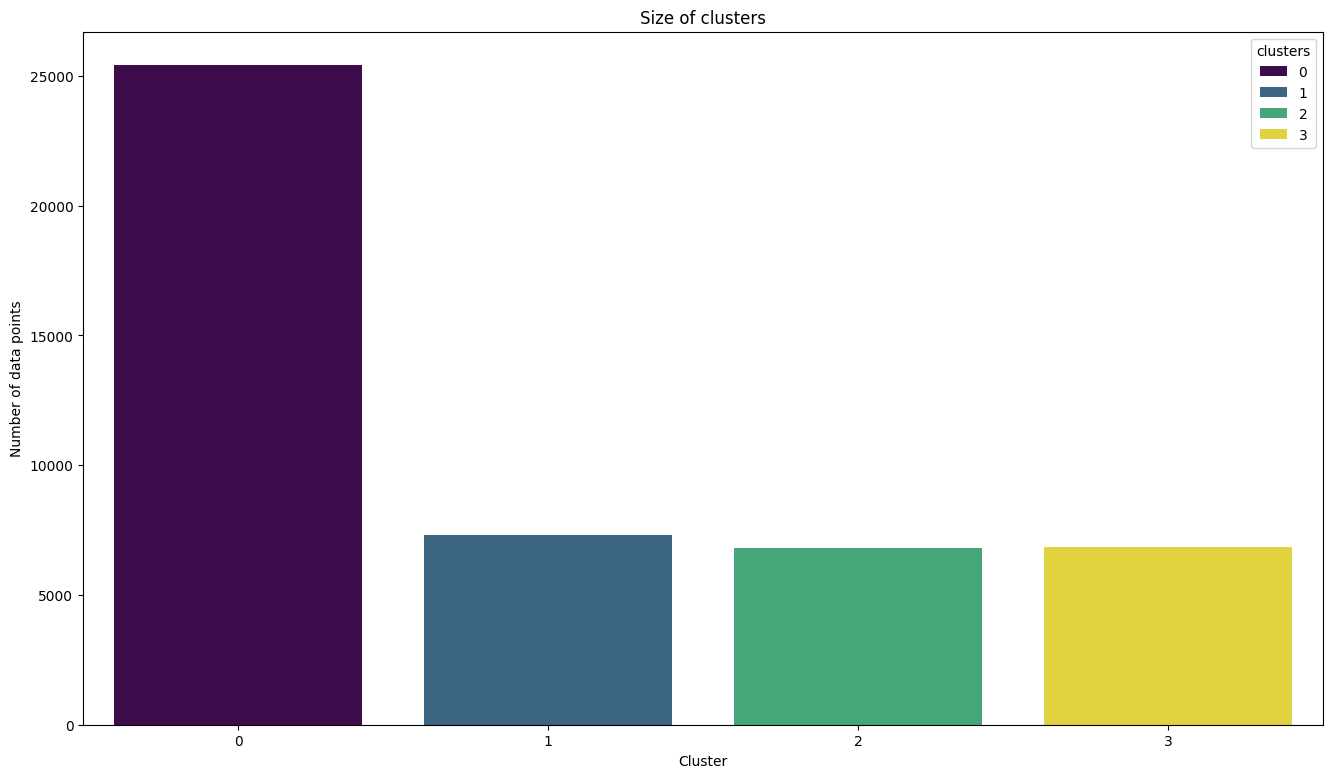

In [48]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_gmm, x="clusters", hue="clusters", palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of data points')
plt.title('Size of clusters')
plt.show()

In [49]:
cluster_sizes = Cluster_all_gmm['clusters'].value_counts()
print(cluster_sizes)

clusters
0    25435
1     7322
3     6837
2     6806
Name: count, dtype: int64


In [50]:
# Trip Duration: long, middle, short
Cluster_all_gmm['trip_duration_category'] = [
    'short' if x < 300 else 'middle' if x < 900 else 'long' 
    for x in Cluster_all_gmm['trip_seconds']
]

# Price per Mile: expensive, middle, cheap
Cluster_all_gmm['price_per_mile_category'] = [
    'cheap' if x < 9.9 else 'middle' if x < 16.0 else 'expensive' 
    for x in Cluster_all_gmm['price_per_mile']
]

# Miles per Hour: fast, middle, slow
Cluster_all_gmm['miles_per_hour_category'] = [
    'slow' if x < 13 else 'middle' if x < 30 else 'fast' 
    for x in Cluster_all_gmm['miles_per_hour']
]

# Trip Miles: long, middle, short
Cluster_all_gmm['trip_miles_category'] = [
    'short' if x < 5 else 'middle' if x < 20 else 'long' 
    for x in Cluster_all_gmm['trip_miles']
]

# Hour: morning, afternoon, evening, night
Cluster_all_gmm['hour_category'] = [
    'night' if x < 5 else 'morning' if x < 6 else 'afternoon' if x < 17 else 'evening'
    for x in Cluster_all_gmm['hour']
]

# Weekday: weekday, weekend
Cluster_all_gmm['weekday_category'] = [
    'weekend' if day >= 5 else 'weekday' 
    for day in Cluster_all_gmm['weekday']
]

# Month: winter, spring, summer, fall (USA)
Cluster_all_gmm['month_category'] = [
    'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' 
    for x in Cluster_all_gmm['month']
]

# Temperature: hot, mild, cold
Cluster_all_gmm['temperature_category'] = [
    'cold' if x < -6.0 else 'mild' if x < 4.0 else 'hot' 
    for x in Cluster_all_gmm['temperature']
]

# Distance to Chicago: near, middle, far
Cluster_all_gmm['distance_to_chicago_category'] = [
    'near' if x < 3 else 'middle' if x < 6 else 'far' 
    for x in Cluster_all_gmm['distance_to_chicago']
]

# Distance from Chicago: near, middle, far
Cluster_all_gmm['distance_from_chicago_category'] = [
    'near' if x < 3 else 'middle' if x < 6 else 'far' 
    for x in Cluster_all_gmm['distance_to_chicago']
]

Cluster_all_gmm.columns


Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'hour', 'weekday', 'month', 'temperature',
       'distance_to_chicago', 'distance_from_chicago', 'clusters',
       'trip_duration_category', 'price_per_mile_category',
       'miles_per_hour_category', 'trip_miles_category', 'hour_category',
       'weekday_category', 'month_category', 'temperature_category',
       'distance_to_chicago_category', 'distance_from_chicago_category'],
      dtype='object')

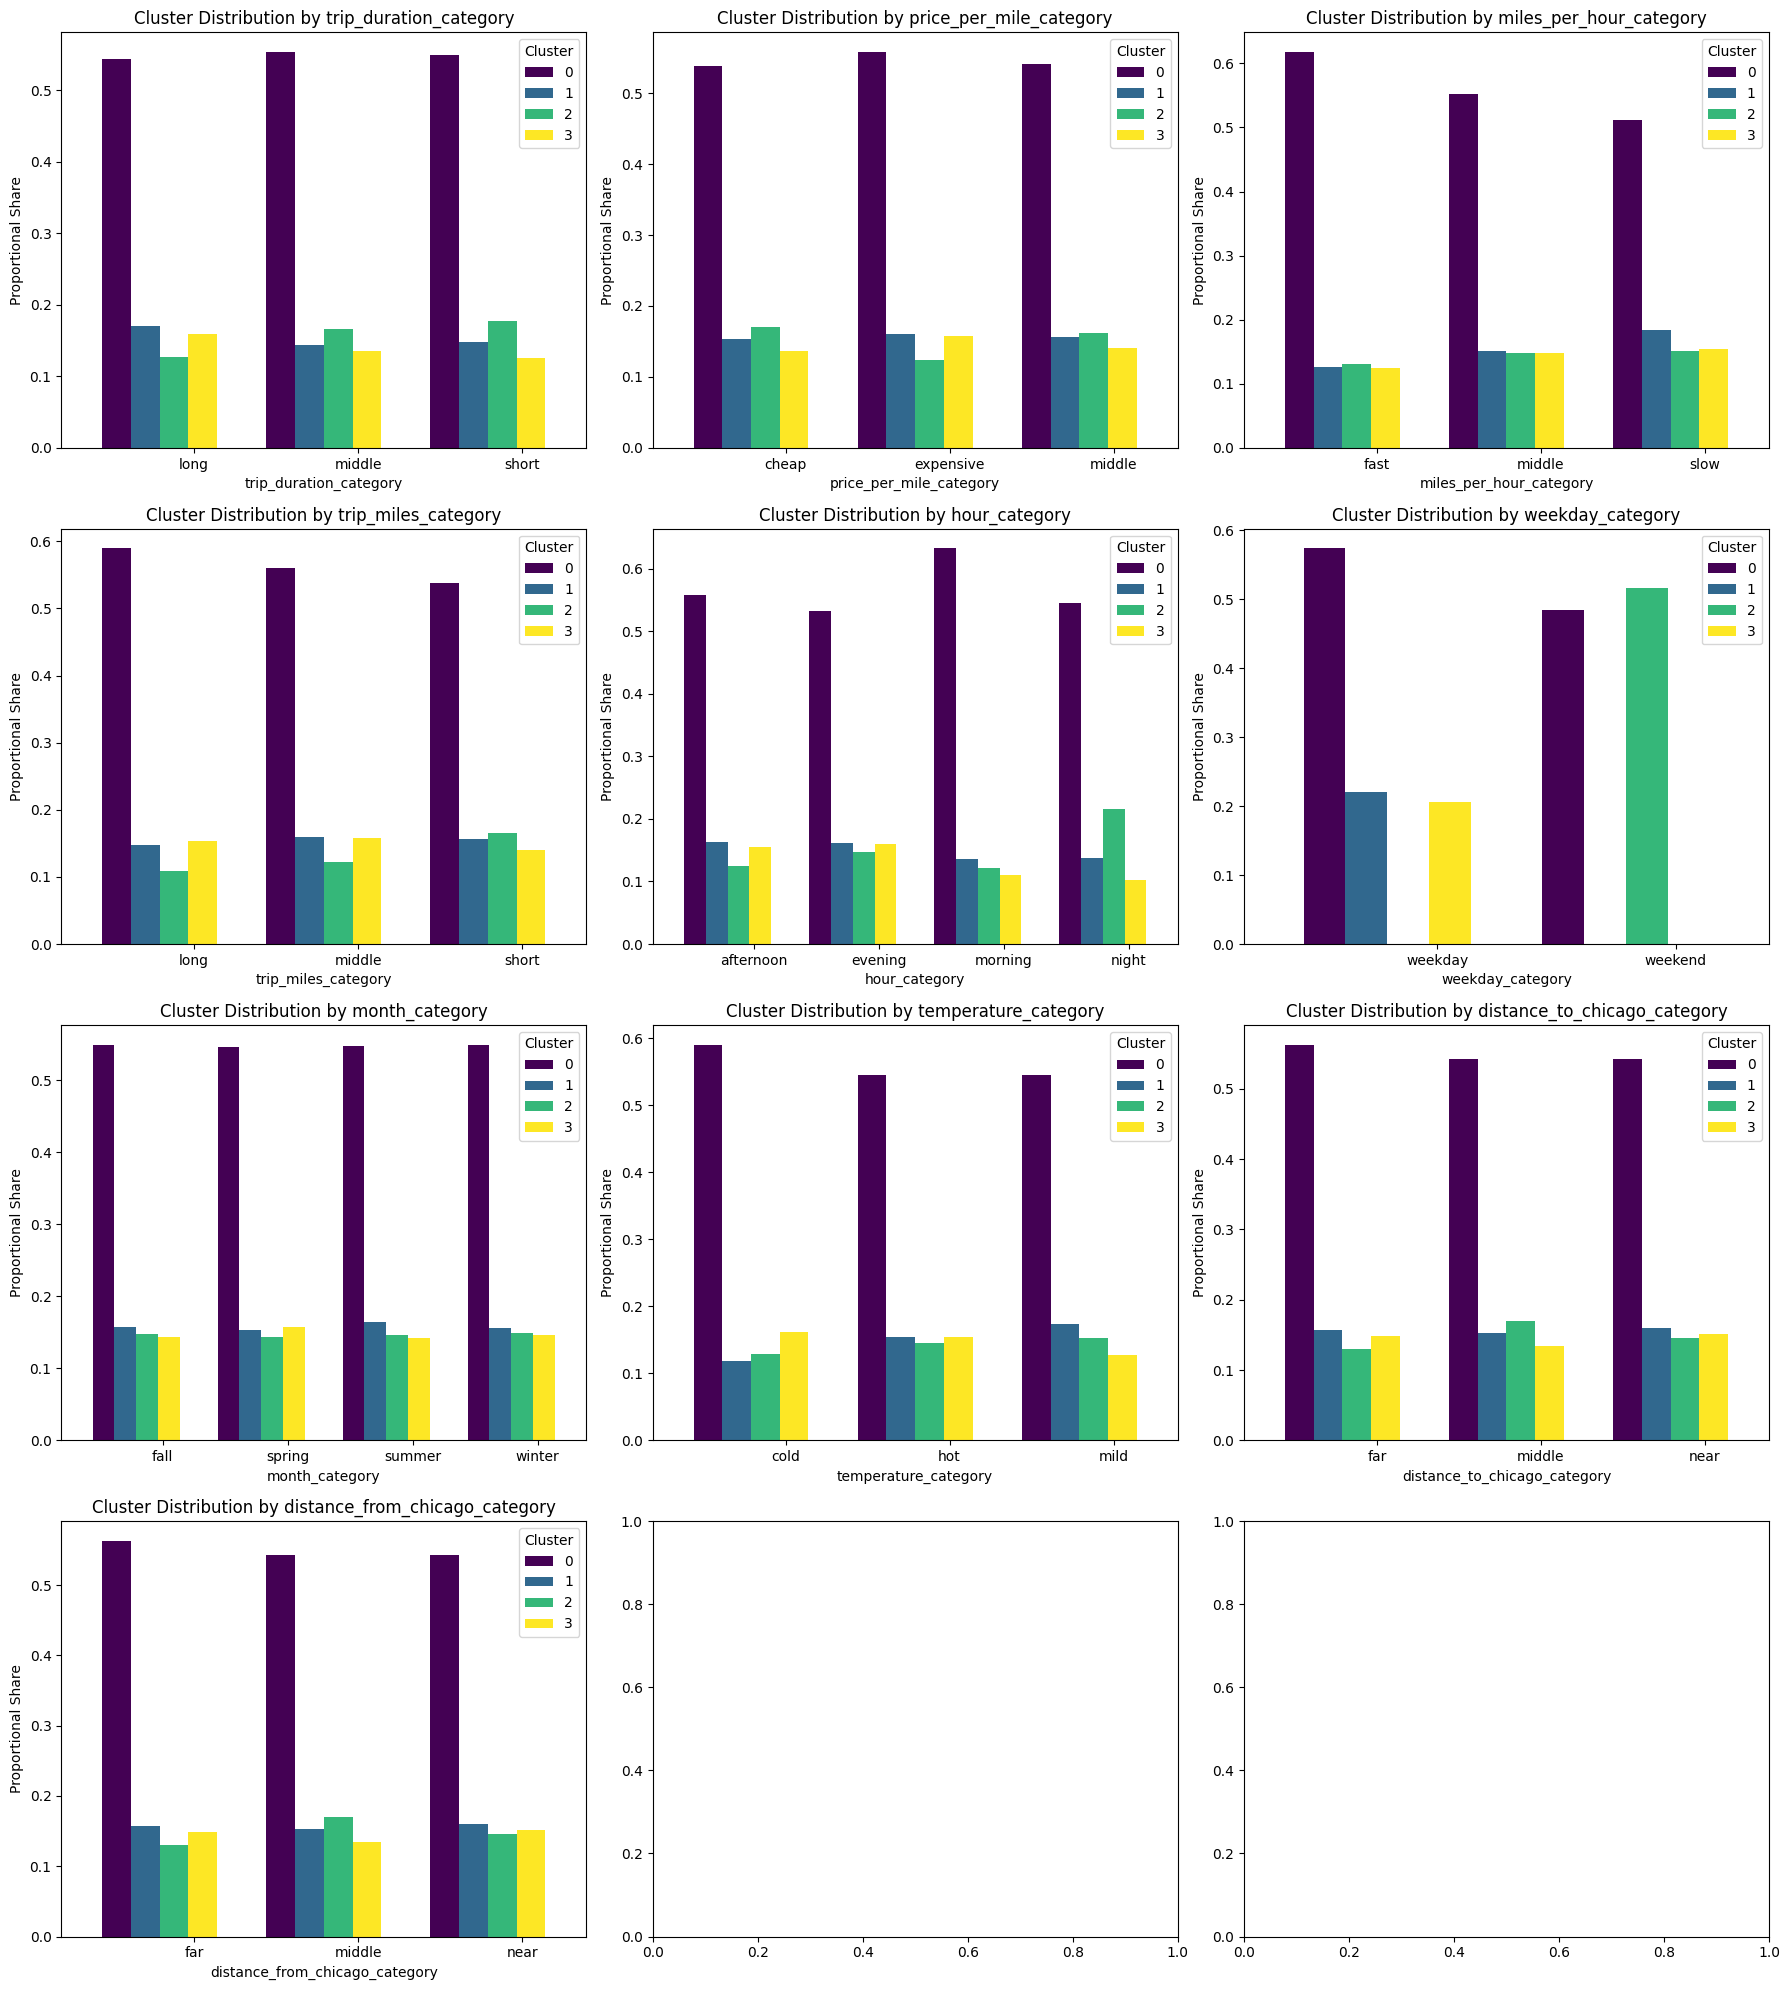

In [51]:
# Erstelle eine Grafik mit 4x3 Subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 20))  # 4 Zeilen, 3 Spalten

# Schleife durch alle Kategorien
for i, category in enumerate(generated_categories):
    ax = axes[i // 3, i % 3]  # Position des Subplots auswählen

    # Erstelle eine Kreuztabelle, um den Anteil der Cluster pro Kategorie zu berechnen
    cross_tab = pd.crosstab(Cluster_all_gmm[category], Cluster_all_gmm['clusters'], normalize='index')

    # Plotten
    cross_tab.plot(kind='bar', stacked=False, position=0.8, width=0.7, colormap='viridis', ax=ax)

    # Achsen und Titel einstellen
    ax.set_title(f'Cluster Distribution by {category}')
    ax.set_xlabel(category)
    ax.set_ylabel('Proportional Share')
    ax.legend(title='Cluster')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

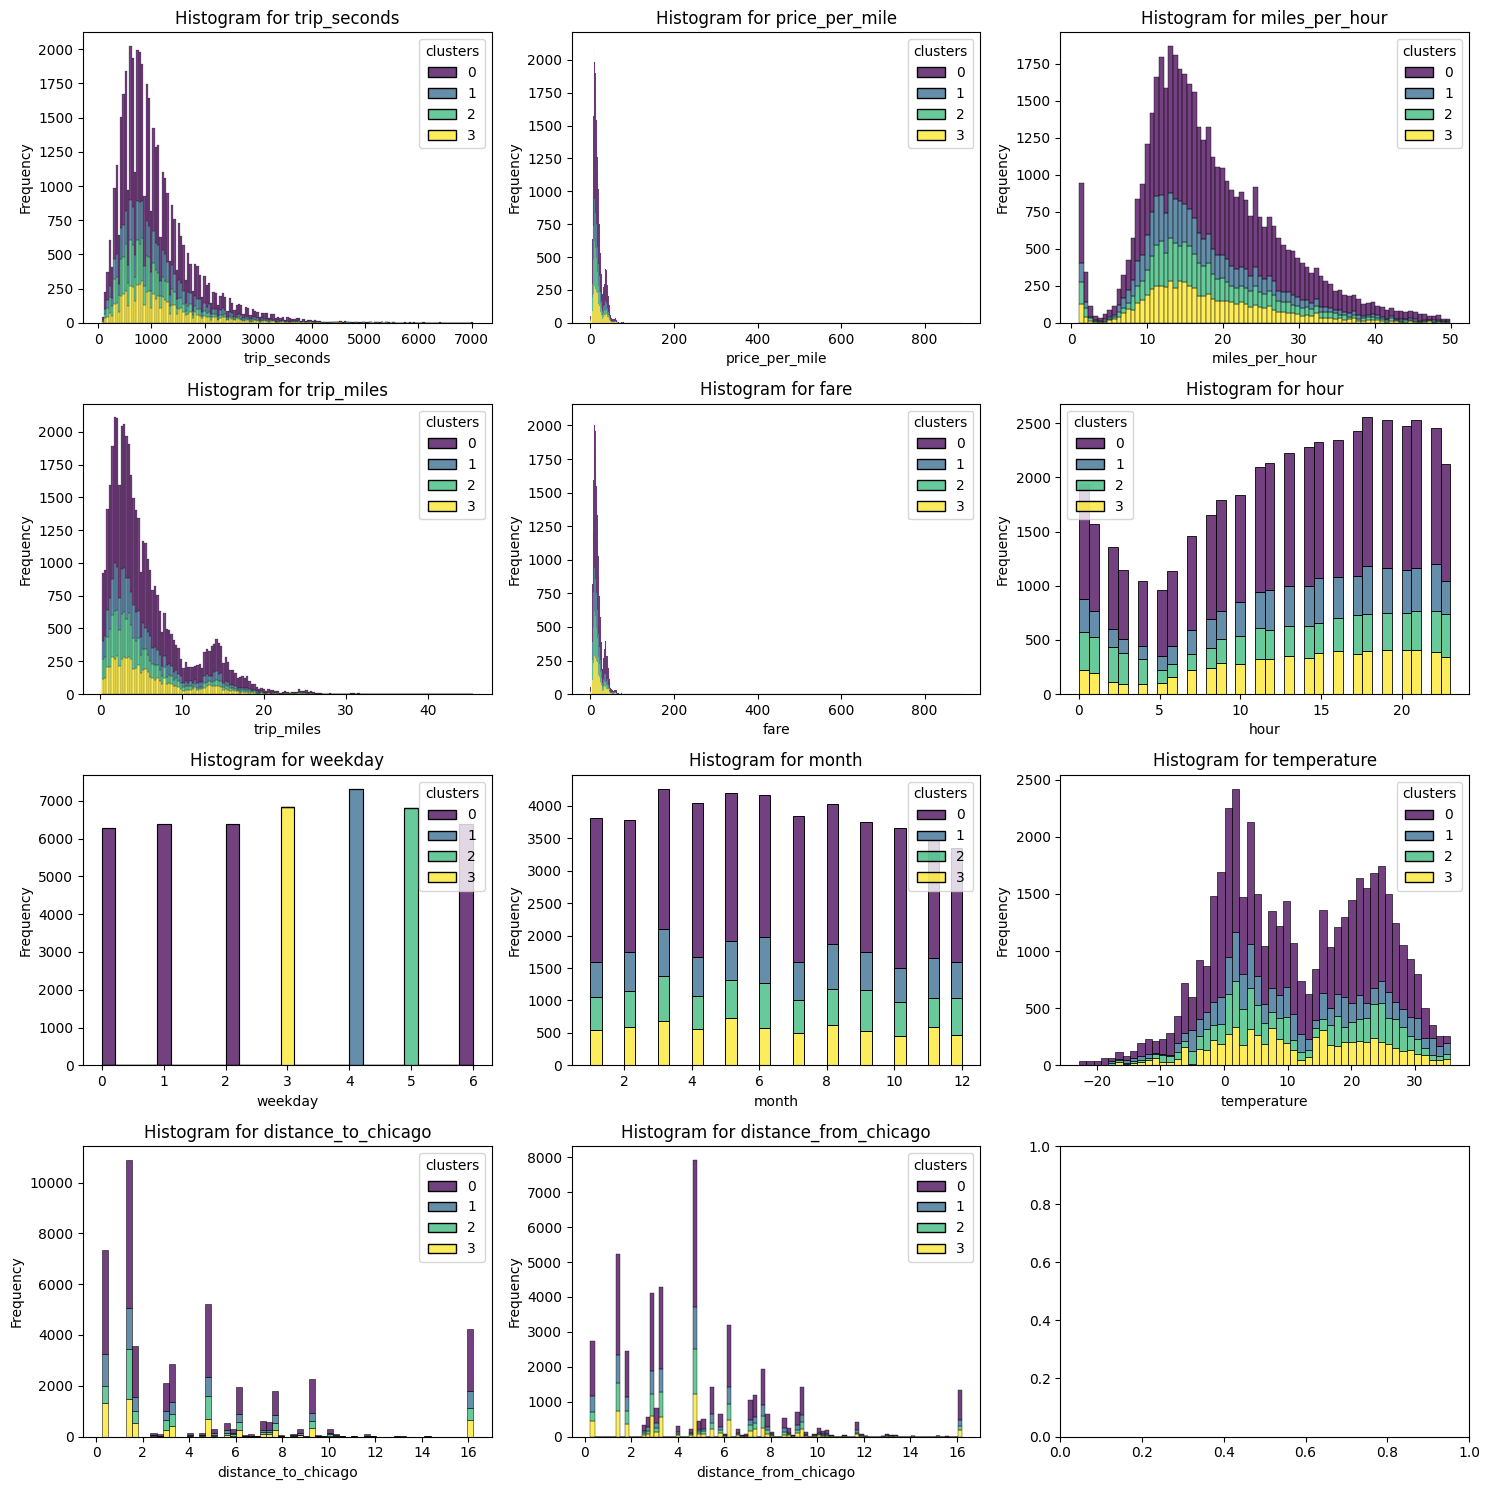

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()


for i, feature in enumerate(features_hard):
    sns.histplot(data=Cluster_all_gmm, x=feature, hue='clusters', multiple='stack', palette='viridis', ax=axes[i])
    
    axes[i].set_title(f'Histogram for {feature}')
    axes[i].set_xlabel(f'{feature}')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

In [53]:
'''Cluster_all_gmm[columns_to_normalize] = scaler.fit_transform(Cluster_all_gmm[columns_to_normalize])'''

'Cluster_all_gmm[columns_to_normalize] = scaler.fit_transform(Cluster_all_gmm[columns_to_normalize])'

# Comparison

In [54]:
'''plt.figure(figsize=(16,9))
numerical_columns = Cluster_all_gmm.columns[Cluster_all_gmm.columns != "clusters"]
pairplot = sns.pairplot(Cluster_all_gmm.sample(n=50, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")

pairplot.savefig("pairplot_gmm.png")

plt.show()'''

'plt.figure(figsize=(16,9))\nnumerical_columns = Cluster_all_gmm.columns[Cluster_all_gmm.columns != "clusters"]\npairplot = sns.pairplot(Cluster_all_gmm.sample(n=50, random_state=42), hue="clusters", vars=numerical_columns, palette="viridis")\n\npairplot.savefig("pairplot_gmm.png")\n\nplt.show()'

In [55]:
'''print(silhouette_score_hard)
print(silhouette_score_soft)

# Vergleiche die Cluster-Zuweisungen
differences = Cluster_all_knn['clusters'] != Cluster_all_gmm['clusters']

print(Cluster_all_knn['clusters'].head(1))
print(Cluster_all_gmm['clusters'].head(1))



#print(differences)

# Anzahl der Unterschiede zählen
num_differences = differences.sum()

print(f"Anzahl der Unterschiede in den Cluster-Zuweisungen: {num_differences}")






#Cluster-Zuweisung vergleichen
#Anzahl (anders) klassifizierte Punkte ausrechnen
#Countplot nebeneinander legen


#Vielleicht lieber mean
#KDE noch verbessern + Mapp hinzufügen
#Ziel des Clusterings?!?!?!?!
#Pair plots auch weg
#Features auswählen

#Code kommentieren'''

'print(silhouette_score_hard)\nprint(silhouette_score_soft)\n\n# Vergleiche die Cluster-Zuweisungen\ndifferences = Cluster_all_knn[\'clusters\'] != Cluster_all_gmm[\'clusters\']\n\nprint(Cluster_all_knn[\'clusters\'].head(1))\nprint(Cluster_all_gmm[\'clusters\'].head(1))\n\n\n\n#print(differences)\n\n# Anzahl der Unterschiede zählen\nnum_differences = differences.sum()\n\nprint(f"Anzahl der Unterschiede in den Cluster-Zuweisungen: {num_differences}")\n\n\n\n\n\n\n#Cluster-Zuweisung vergleichen\n#Anzahl (anders) klassifizierte Punkte ausrechnen\n#Countplot nebeneinander legen\n\n\n#Vielleicht lieber mean\n#KDE noch verbessern + Mapp hinzufügen\n#Ziel des Clusterings?!?!?!?!\n#Pair plots auch weg\n#Features auswählen\n\n#Code kommentieren'

# Spatial Kernel Density Estimation

In [56]:
'''bw_adjust = 1

data['geometry'] = data['pickup_centroid_location'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(data, geometry='geometry')

plt.figure(figsize=(10, 8))
# Gaussian Kernel is standard kernel, that cannot be changed
sns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, cmap="Reds", bw_adjust=bw_adjust)
plt.scatter(gdf.geometry.x, gdf.geometry.y)
plt.title("Kernel Density Estimation (KDE) of Pickup Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()'''

'bw_adjust = 1\n\ndata[\'geometry\'] = data[\'pickup_centroid_location\'].apply(wkt.loads)\n\ngdf = gpd.GeoDataFrame(data, geometry=\'geometry\')\n\nplt.figure(figsize=(10, 8))\n# Gaussian Kernel is standard kernel, that cannot be changed\nsns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, cmap="Reds", bw_adjust=bw_adjust)\nplt.scatter(gdf.geometry.x, gdf.geometry.y)\nplt.title("Kernel Density Estimation (KDE) of Pickup Locations")\nplt.xlabel("Longitude")\nplt.ylabel("Latitude")\nplt.show()'

In [57]:
'''data['geometry'] = data['dropoff_centroid_location'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(data, geometry='geometry')

plt.figure(figsize=(10, 8))
sns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, cmap="Reds", bw_adjust=bw_adjust)
plt.scatter(gdf.geometry.x, gdf.geometry.y)
plt.title("Kernel Density Estimation (KDE) of Drop Off Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()'''

'data[\'geometry\'] = data[\'dropoff_centroid_location\'].apply(wkt.loads)\n\ngdf = gpd.GeoDataFrame(data, geometry=\'geometry\')\n\nplt.figure(figsize=(10, 8))\nsns.kdeplot(x=gdf.geometry.x, y=gdf.geometry.y, cmap="Reds", bw_adjust=bw_adjust)\nplt.scatter(gdf.geometry.x, gdf.geometry.y)\nplt.title("Kernel Density Estimation (KDE) of Drop Off Locations")\nplt.xlabel("Longitude")\nplt.ylabel("Latitude")\nplt.show()'

# Results